# Data Preparation

### Loading Dataset

In [1]:
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import warnings
warnings.simplefilter("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sklearn
sklearn.__version__

'1.0.1'

In [3]:
import pandas as pd
import numpy as np
import pandas_profiling
from pandas_profiling import ProfileReport

In [4]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [5]:
#!pip install wandb
#!pip install category_encoders

In [6]:
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score
from xgboost import XGBClassifier
import wandb
import os

In [7]:
# Loading the dataset
hr_df = pd.read_csv('Employee_Attrition.csv')

In [8]:
hr_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [9]:
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [10]:
hr_df['Attrition']=hr_df['Attrition'].map(dict(Yes=1,No=0))

In [11]:
#Splitting dataset into development and production datasets
hr_df_dev, hr_df_prod = train_test_split(hr_df,
                                             train_size = 0.8,
                                             random_state = 42)

### Data Profiling

In [12]:
#profile = ProfileReport(hr_df, title = 'Employee Attrition Profiling Report')

In [13]:
#profile.to_notebook_iframe()

In [14]:
#profile.to_file("emloyee_attrition.html")

### Preliminary data preparation

In [15]:
# removing redundant features
redunt_features = ['EmployeeCount','EmployeeNumber','StandardHours','Over18']
hr_df_dev.drop(redunt_features, inplace=True, axis=1)

In [16]:
# splitting numeric and categorical features
cat_features = ['BusinessTravel', 'Department','Education','EnvironmentSatisfaction',
                'EducationField','Gender','JobInvolvement','JobLevel','JobRole','JobSatisfaction',
                'MaritalStatus','PerformanceRating','RelationshipSatisfaction',
                'StockOptionLevel','WorkLifeBalance','OverTime']
num_features = list(hr_df_dev.columns)
num_features.remove('Attrition')
num_features = list(set(num_features) - set(cat_features))

In [17]:
# separating into predictors and labels
X_dev = hr_df_dev[num_features + cat_features]
y_dev = hr_df_dev['Attrition']

### Splitting dataset into train and test set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_dev,
                                                    y_dev,
                                                    train_size = 0.8,
                                                    random_state = 100)

In [19]:
X_train.shape

(940, 30)

### Handling imbalanced dataset

In [20]:
from imblearn.over_sampling import SMOTENC

In [21]:
sm=SMOTENC(random_state=42, categorical_features=list(range(14,30)))
X_train, y_train = sm.fit_resample(X_train, y_train)

In [22]:
X_train.head()

,YearsSinceLastPromotion,MonthlyIncome,DailyRate,HourlyRate,PercentSalaryHike,Age,YearsInCurrentRole,YearsAtCompany,MonthlyRate,TrainingTimesLastYear,TotalWorkingYears,DistanceFromHome,NumCompaniesWorked,YearsWithCurrManager,BusinessTravel,Department,Education,EnvironmentSatisfaction,EducationField,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,WorkLifeBalance,OverTime
0,1,2439,459,73,24,29,0,1,14753,3,1,24,1,0,Travel_Frequently,Research & Development,2,4,Life Sciences,Male,2,1,Research Scientist,4,Single,4,2,0,2,Yes
1,1,2778,1085,57,13,41,7,7,17725,1,10,2,4,0,Travel_Rarely,Research & Development,4,2,Life Sciences,Female,1,1,Laboratory Technician,4,Divorced,3,3,1,2,Yes
2,1,2546,408,71,16,29,2,2,18300,2,6,25,5,1,Travel_Rarely,Research & Development,5,3,Technical Degree,Female,2,1,Research Scientist,2,Married,3,2,0,4,No
3,2,4787,1092,36,14,29,2,2,26124,3,4,1,9,2,Travel_Rarely,Research & Development,4,1,Medical,Male,3,1,Research Scientist,4,Married,3,2,3,4,Yes
4,0,2561,289,38,11,28,0,0,5355,2,8,2,7,0,Travel_Frequently,Research & Development,2,3,Medical,Male,2,1,Laboratory Technician,1,Single,3,3,0,2,No


### Scaling and encoding

In [23]:
#Scaling training data
numeric_transformer = StandardScaler()
numeric_transformer.fit(X_train[num_features])
scaled_num_array = numeric_transformer.transform(X_train[num_features])
scaled_num_train_df = pd.DataFrame(scaled_num_array, columns = num_features)
scaled_num_train_df

StandardScaler()

,YearsSinceLastPromotion,MonthlyIncome,DailyRate,HourlyRate,PercentSalaryHike,Age,YearsInCurrentRole,YearsAtCompany,MonthlyRate,TrainingTimesLastYear,TotalWorkingYears,DistanceFromHome,NumCompaniesWorked,YearsWithCurrManager
0,-0.280540,-0.743459,-0.854367,0.314641,2.592974,-0.706106,-1.027824,-0.826428,0.045734,0.362280,-1.172950,1.902720,-0.725103,-1.027971
1,-0.280540,-0.664507,0.804075,-0.530117,-0.599529,0.626267,1.099492,0.193275,0.457445,-1.291421,0.020680,-0.978276,0.515191,-1.027971
2,-0.280540,-0.718539,-0.989479,0.209046,0.271153,-0.706106,-0.420020,-0.656477,0.537100,-0.464571,-0.509822,2.033674,0.928622,-0.716671
3,0.074597,-0.196619,0.822620,-1.638862,-0.309302,-0.706106,-0.420020,-0.656477,1.620960,0.362280,-0.775073,-1.109231,2.582348,-0.405372
4,-0.635677,-0.715046,-1.304742,-1.533267,-1.179984,-0.817137,-1.027824,-0.996378,-1.256173,-0.464571,-0.244571,-0.978276,1.755485,-1.027971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,-0.635677,-0.652397,1.132584,-0.530117,-0.889757,-0.484044,-1.027824,-0.826428,0.746281,-0.464571,-1.040324,1.509857,-0.311672,-1.027971
1548,-0.635677,-0.822178,0.520603,-0.424522,-0.309302,0.404205,-1.027824,-0.826428,-1.536004,2.015981,0.949059,-0.585413,0.101760,-1.027971
1549,-0.635677,-0.769077,-0.790784,-0.107738,0.851608,-1.039199,-1.027824,-0.826428,1.219915,0.362280,-1.172950,1.771766,-0.725103,-1.027971
1550,0.074597,1.098982,-0.313916,-0.688509,-1.179984,0.404205,0.491687,1.212977,-1.224172,2.015981,0.683808,-0.323505,-0.311672,0.528528


In [24]:
#Scaling test data
numeric_transformer = StandardScaler()
numeric_transformer.fit(X_test[num_features])
scaled_num_array = numeric_transformer.transform(X_test[num_features])
scaled_num_test_df = pd.DataFrame(scaled_num_array, columns = num_features)
scaled_num_test_df

StandardScaler()

,YearsSinceLastPromotion,MonthlyIncome,DailyRate,HourlyRate,PercentSalaryHike,Age,YearsInCurrentRole,YearsAtCompany,MonthlyRate,TrainingTimesLastYear,TotalWorkingYears,DistanceFromHome,NumCompaniesWorked,YearsWithCurrManager
0,0.187672,1.097869,-1.438186,-0.851770,-1.127934,-0.414105,1.163044,0.965528,1.564801,0.039443,0.403429,-0.299532,-1.063611,0.735331
1,-0.109580,1.832995,-1.058537,1.086684,2.507864,1.216519,-0.691540,-0.874788,-1.214257,0.039443,1.596858,-0.672892,-0.249957,-0.609926
2,-0.704084,-0.823383,1.738884,0.602070,-1.127934,-0.957646,-0.956480,-1.042090,1.150524,0.755493,-1.320414,0.322735,-0.656784,-1.148028
3,0.187672,-0.707597,0.539989,0.602070,-0.608534,-0.522813,0.633163,-0.038281,-0.360903,-0.676606,-0.392191,-0.921799,-1.063611,0.466280
4,-0.109580,1.397070,-1.535597,-0.512540,0.430265,1.325227,0.898103,0.296322,-0.358858,0.039443,1.464255,-0.175079,1.377351,-0.340874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,0.187672,-0.822546,0.372644,0.602070,1.469065,-0.087980,0.898103,0.630925,-0.303258,2.187592,0.668635,-0.921799,0.563697,1.273433
232,1.376680,0.418437,0.602432,-0.124850,0.949665,1.651352,0.633163,0.129021,0.956877,-0.676606,-0.126984,-0.548439,2.597832,0.735331
233,-0.406832,-0.591602,-1.335781,0.795916,-0.608534,-0.305396,0.103282,-0.205582,1.128584,0.039443,-0.657398,-1.046253,-0.656784,-0.340874
234,-0.704084,0.706960,1.763861,0.456686,0.949665,0.129436,-1.221421,-1.042090,1.044093,0.755493,0.933842,0.073828,0.156870,-1.148028


In [25]:
def OneHotEncoding(categorical_features,df):
    ohe_encoder = OneHotEncoder(handle_unknown='ignore')
    ohe_encoder.fit(df[categorical_features])
    encoded_cat_names = list(ohe_encoder.get_feature_names())
    encoded_cols_df = ohe_encoder.transform(df[categorical_features])
    return encoded_cols_df

In [26]:
ohe_encoded_cat_train_df = OneHotEncoding(cat_features,X_train)
ohe_encoded_cat_train_df

,BusinessTravel_1,BusinessTravel_2,BusinessTravel_3,Department_1,Department_2,Department_3,Education,EnvironmentSatisfaction,EducationField_1,EducationField_2,EducationField_3,EducationField_4,EducationField_5,EducationField_6,Gender_1,Gender_2,JobInvolvement,JobLevel,JobRole_1,JobRole_2,JobRole_3,JobRole_4,JobRole_5,JobRole_6,JobRole_7,JobRole_8,JobRole_9,JobSatisfaction,MaritalStatus_1,MaritalStatus_2,MaritalStatus_3,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,WorkLifeBalance,OverTime_1,OverTime_2
0,1,0,0,1,0,0,2,4,1,0,0,0,0,0,1,0,2,1,1,0,0,0,0,0,0,0,0,4,1,0,0,4,2,0,2,1,0
1,0,1,0,1,0,0,4,2,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,4,0,1,0,3,3,1,2,1,0
2,0,1,0,1,0,0,5,3,0,1,0,0,0,0,0,1,2,1,1,0,0,0,0,0,0,0,0,2,0,0,1,3,2,0,4,0,1
3,0,1,0,1,0,0,4,1,0,0,1,0,0,0,1,0,3,1,1,0,0,0,0,0,0,0,0,4,0,0,1,3,2,3,4,1,0
4,1,0,0,1,0,0,2,3,0,0,1,0,0,0,1,0,2,1,0,1,0,0,0,0,0,0,0,1,1,0,0,3,3,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,1,0,0,1,0,0,3,3,1,0,0,0,0,0,1,0,3,1,0,1,0,0,0,0,0,0,0,3,0,1,0,3,4,0,2,1,0
1548,0,1,0,1,0,0,3,4,0,1,0,0,0,0,1,0,3,1,0,1,0,0,0,0,0,0,0,2,0,0,1,3,3,0,3,0,1
1549,0,1,0,1,0,0,3,3,1,0,0,0,0,0,1,0,3,1,0,1,0,0,0,0,0,0,0,4,1,0,0,3,3,0,3,1,0
1550,0,1,0,0,1,0,3,2,0,0,1,0,0,0,1,0,2,3,0,0,1,0,0,0,0,0,0,1,0,0,1,3,4,1,3,0,1


In [27]:
X_train_fs = scaled_num_train_df.join(ohe_encoded_cat_train_df)
X_train_fs

,YearsSinceLastPromotion,MonthlyIncome,DailyRate,HourlyRate,PercentSalaryHike,Age,YearsInCurrentRole,YearsAtCompany,MonthlyRate,TrainingTimesLastYear,TotalWorkingYears,DistanceFromHome,NumCompaniesWorked,YearsWithCurrManager,BusinessTravel_1,BusinessTravel_2,BusinessTravel_3,Department_1,Department_2,Department_3,Education,EnvironmentSatisfaction,EducationField_1,EducationField_2,EducationField_3,EducationField_4,EducationField_5,EducationField_6,Gender_1,Gender_2,JobInvolvement,JobLevel,JobRole_1,JobRole_2,JobRole_3,JobRole_4,JobRole_5,JobRole_6,JobRole_7,JobRole_8,JobRole_9,JobSatisfaction,MaritalStatus_1,MaritalStatus_2,MaritalStatus_3,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,WorkLifeBalance,OverTime_1,OverTime_2
0,-0.280540,-0.743459,-0.854367,0.314641,2.592974,-0.706106,-1.027824,-0.826428,0.045734,0.362280,-1.172950,1.902720,-0.725103,-1.027971,1,0,0,1,0,0,2,4,1,0,0,0,0,0,1,0,2,1,1,0,0,0,0,0,0,0,0,4,1,0,0,4,2,0,2,1,0
1,-0.280540,-0.664507,0.804075,-0.530117,-0.599529,0.626267,1.099492,0.193275,0.457445,-1.291421,0.020680,-0.978276,0.515191,-1.027971,0,1,0,1,0,0,4,2,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,4,0,1,0,3,3,1,2,1,0
2,-0.280540,-0.718539,-0.989479,0.209046,0.271153,-0.706106,-0.420020,-0.656477,0.537100,-0.464571,-0.509822,2.033674,0.928622,-0.716671,0,1,0,1,0,0,5,3,0,1,0,0,0,0,0,1,2,1,1,0,0,0,0,0,0,0,0,2,0,0,1,3,2,0,4,0,1
3,0.074597,-0.196619,0.822620,-1.638862,-0.309302,-0.706106,-0.420020,-0.656477,1.620960,0.362280,-0.775073,-1.109231,2.582348,-0.405372,0,1,0,1,0,0,4,1,0,0,1,0,0,0,1,0,3,1,1,0,0,0,0,0,0,0,0,4,0,0,1,3,2,3,4,1,0
4,-0.635677,-0.715046,-1.304742,-1.533267,-1.179984,-0.817137,-1.027824,-0.996378,-1.256173,-0.464571,-0.244571,-0.978276,1.755485,-1.027971,1,0,0,1,0,0,2,3,0,0,1,0,0,0,1,0,2,1,0,1,0,0,0,0,0,0,0,1,1,0,0,3,3,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,-0.635677,-0.652397,1.132584,-0.530117,-0.889757,-0.484044,-1.027824,-0.826428,0.746281,-0.464571,-1.040324,1.509857,-0.311672,-1.027971,1,0,0,1,0,0,3,3,1,0,0,0,0,0,1,0,3,1,0,1,0,0,0,0,0,0,0,3,0,1,0,3,4,0,2,1,0
1548,-0.635677,-0.822178,0.520603,-0.424522,-0.309302,0.404205,-1.027824,-0.826428,-1.536004,2.015981,0.949059,-0.585413,0.101760,-1.027971,0,1,0,1,0,0,3,4,0,1,0,0,0,0,1,0,3,1,0,1,0,0,0,0,0,0,0,2,0,0,1,3,3,0,3,0,1
1549,-0.635677,-0.769077,-0.790784,-0.107738,0.851608,-1.039199,-1.027824,-0.826428,1.219915,0.362280,-1.172950,1.771766,-0.725103,-1.027971,0,1,0,1,0,0,3,3,1,0,0,0,0,0,1,0,3,1,0,1,0,0,0,0,0,0,0,4,1,0,0,3,3,0,3,1,0
1550,0.074597,1.098982,-0.313916,-0.688509,-1.179984,0.404205,0.491687,1.212977,-1.224172,2.015981,0.683808,-0.323505,-0.311672,0.528528,0,1,0,0,1,0,3,2,0,0,1,0,0,0,1,0,2,3,0,0,1,0,0,0,0,0,0,1,0,0,1,3,4,1,3,0,1


In [28]:
ohe_encoded_cat_test_df = OneHotEncoding(cat_features,X_test)
ohe_encoded_cat_test_df = ohe_encoded_cat_test_df.reset_index(drop=True)

In [29]:
X_test_fs =scaled_num_test_df .join(ohe_encoded_cat_test_df)
X_test_fs

,YearsSinceLastPromotion,MonthlyIncome,DailyRate,HourlyRate,PercentSalaryHike,Age,YearsInCurrentRole,YearsAtCompany,MonthlyRate,TrainingTimesLastYear,TotalWorkingYears,DistanceFromHome,NumCompaniesWorked,YearsWithCurrManager,BusinessTravel_1,BusinessTravel_2,BusinessTravel_3,Department_1,Department_2,Department_3,Education,EnvironmentSatisfaction,EducationField_1,EducationField_2,EducationField_3,EducationField_4,EducationField_5,EducationField_6,Gender_1,Gender_2,JobInvolvement,JobLevel,JobRole_1,JobRole_2,JobRole_3,JobRole_4,JobRole_5,JobRole_6,JobRole_7,JobRole_8,JobRole_9,JobSatisfaction,MaritalStatus_1,MaritalStatus_2,MaritalStatus_3,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,WorkLifeBalance,OverTime_1,OverTime_2
0,0.187672,1.097869,-1.438186,-0.851770,-1.127934,-0.414105,1.163044,0.965528,1.564801,0.039443,0.403429,-0.299532,-1.063611,0.735331,1,0,0,1,0,0,3,3,1,0,0,0,0,0,1,0,3,3,1,0,0,0,0,0,0,0,0,3,1,0,0,3,4,0,4,1,0
1,-0.109580,1.832995,-1.058537,1.086684,2.507864,1.216519,-0.691540,-0.874788,-1.214257,0.039443,1.596858,-0.672892,-0.249957,-0.609926,0,1,0,1,0,0,5,3,1,0,0,0,0,0,1,0,2,4,0,1,0,0,0,0,0,0,0,4,1,0,0,4,2,1,3,1,0
2,-0.704084,-0.823383,1.738884,0.602070,-1.127934,-0.957646,-0.956480,-1.042090,1.150524,0.755493,-1.320414,0.322735,-0.656784,-1.148028,1,0,0,1,0,0,1,3,0,1,0,0,0,0,0,1,3,1,0,0,1,0,0,0,0,0,0,4,1,0,0,3,4,0,2,0,1
3,0.187672,-0.707597,0.539989,0.602070,-0.608534,-0.522813,0.633163,-0.038281,-0.360903,-0.676606,-0.392191,-0.921799,-1.063611,0.466280,0,1,0,1,0,0,2,4,0,1,0,0,0,0,1,0,3,1,0,0,1,0,0,0,0,0,0,4,0,1,0,3,3,0,2,1,0
4,-0.109580,1.397070,-1.535597,-0.512540,0.430265,1.325227,0.898103,0.296322,-0.358858,0.039443,1.464255,-0.175079,1.377351,-0.340874,1,0,0,0,1,0,4,4,0,0,1,0,0,0,1,0,2,4,0,0,0,1,0,0,0,0,0,2,1,0,0,3,2,1,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,0.187672,-0.822546,0.372644,0.602070,1.469065,-0.087980,0.898103,0.630925,-0.303258,2.187592,0.668635,-0.921799,0.563697,1.273433,1,0,0,1,0,0,4,3,1,0,0,0,0,0,1,0,3,1,0,0,1,0,0,0,0,0,0,3,0,1,0,4,3,0,3,1,0
232,1.376680,0.418437,0.602432,-0.124850,0.949665,1.651352,0.633163,0.129021,0.956877,-0.676606,-0.126984,-0.548439,2.597832,0.735331,1,0,0,0,1,0,3,2,0,1,0,0,0,0,1,0,3,3,0,0,0,1,0,0,0,0,0,2,0,1,0,3,3,0,2,0,1
233,-0.406832,-0.591602,-1.335781,0.795916,-0.608534,-0.305396,0.103282,-0.205582,1.128584,0.039443,-0.657398,-1.046253,-0.656784,-0.340874,1,0,0,1,0,0,2,2,0,1,0,0,0,0,1,0,2,1,0,0,0,0,1,0,0,0,0,4,1,0,0,3,4,1,3,0,1
234,-0.704084,0.706960,1.763861,0.456686,0.949665,0.129436,-1.221421,-1.042090,1.044093,0.755493,0.933842,0.073828,0.156870,-1.148028,1,0,0,1,0,0,3,3,1,0,0,0,0,0,0,1,3,2,0,0,0,0,0,1,0,0,0,3,1,0,0,3,3,1,3,1,0


### Feature Selection

In [30]:
# L1 based
logreg = LogisticRegression( penalty = 'l1', C = 1.0, solver = 'liblinear' )
logreg.fit(X_train_fs, y_train)
print(classification_report( y_test, 
                            logreg.predict(X_test_fs)))
l1_selection_df = pd.DataFrame( {"features": list(X_train_fs.columns),
                                 "coef": np.round(logreg.coef_[0], 2)} )
l1_selection_df[l1_selection_df.coef == 0.0]

LogisticRegression(penalty='l1', solver='liblinear')

              precision    recall  f1-score   support

           0       0.86      0.61      0.71       202
           1       0.15      0.41      0.22        34

    accuracy                           0.58       236
   macro avg       0.51      0.51      0.47       236
weighted avg       0.76      0.58      0.64       236



,features,coef
8,MonthlyRate,-0.0
10,TotalWorkingYears,0.0
18,Department_2,0.0
19,Department_3,0.0
22,EducationField_1,0.0
29,Gender_2,0.0
43,MaritalStatus_2,0.0
50,OverTime_2,0.0


In [31]:
remove_features_l1=list(l1_selection_df[l1_selection_df.coef == 0.0].features)

In [32]:
selected_features_l1=list(set(X_train_fs.columns)-set(remove_features_l1))
selected_features_l1

['MonthlyIncome',
 'JobRole_6',
 'MaritalStatus_1',
 'YearsAtCompany',
 'WorkLifeBalance',
 'EducationField_2',
 'OverTime_1',
 'JobRole_2',
 'MaritalStatus_3',
 'PerformanceRating',
 'Department_1',
 'EducationField_5',
 'JobRole_4',
 'JobRole_1',
 'Gender_1',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'EducationField_6',
 'Education',
 'JobInvolvement',
 'JobRole_9',
 'RelationshipSatisfaction',
 'EducationField_4',
 'HourlyRate',
 'YearsInCurrentRole',
 'JobRole_3',
 'DistanceFromHome',
 'BusinessTravel_1',
 'NumCompaniesWorked',
 'JobRole_7',
 'JobSatisfaction',
 'BusinessTravel_2',
 'YearsSinceLastPromotion',
 'JobRole_5',
 'JobRole_8',
 'EnvironmentSatisfaction',
 'DailyRate',
 'PercentSalaryHike',
 'Age',
 'BusinessTravel_3',
 'EducationField_3',
 'YearsWithCurrManager',
 'JobLevel']

In [33]:
## Checking accuracy on baseline model (Logistic) with feature selection using L1
logreg=LogisticRegression()
logreg.fit(X_train_fs[selected_features_l1], y_train)
print(classification_report( y_test, 
                            logreg.predict(X_test_fs[selected_features_l1])))

LogisticRegression()

              precision    recall  f1-score   support

           0       0.86      0.59      0.70       202
           1       0.15      0.44      0.23        34

    accuracy                           0.57       236
   macro avg       0.51      0.52      0.47       236
weighted avg       0.76      0.57      0.64       236



In [34]:
#### Sequential Feature Selection

from sklearn.feature_selection import SequentialFeatureSelector
tree = DecisionTreeClassifier( max_depth = 10 )
sfs = SequentialFeatureSelector(tree, n_features_to_select=25)
sfs.fit(X_train_fs, y_train)
selected_features_sfs= [feature for feature, selected in zip(list(X_train_fs.columns), sfs.support_) if selected == True]
selected_features_sfs

SequentialFeatureSelector(estimator=DecisionTreeClassifier(max_depth=10),
                          n_features_to_select=25)

['YearsSinceLastPromotion',
 'DailyRate',
 'PercentSalaryHike',
 'YearsAtCompany',
 'MonthlyRate',
 'TrainingTimesLastYear',
 'TotalWorkingYears',
 'YearsWithCurrManager',
 'BusinessTravel_1',
 'BusinessTravel_3',
 'Department_1',
 'Department_3',
 'Education',
 'EducationField_5',
 'EducationField_6',
 'Gender_2',
 'JobRole_5',
 'JobRole_6',
 'JobRole_7',
 'JobRole_8',
 'JobRole_9',
 'MaritalStatus_2',
 'StockOptionLevel',
 'OverTime_1',
 'OverTime_2']

In [35]:
## Checking accuracy on baseline model (Logistic) with feature selection using SFS
logreg=LogisticRegression()
logreg.fit(X_train_fs[selected_features_sfs], y_train)
print(classification_report( y_test, 
                            logreg.predict(X_test_fs[selected_features_sfs])))

LogisticRegression()

              precision    recall  f1-score   support

           0       0.85      0.61      0.71       202
           1       0.14      0.38      0.21        34

    accuracy                           0.58       236
   macro avg       0.50      0.50      0.46       236
weighted avg       0.75      0.58      0.64       236



In [36]:
#### Recursive Feature Elimination (RFE)

from sklearn.feature_selection import RFE
rfe_selector = RFE(tree, 
                   n_features_to_select=25, 
                   step=1, 
                   verbose=1)
rfe_selector.fit(X_train_fs, y_train)
features_rfe = pd.DataFrame({"features": list(X_train_fs.columns),
                             "rank": rfe_selector.ranking_})
pd.set_option('display.max_rows', 1000)
sorted_features_rfe=features_rfe.sort_values("rank", ascending=True)
sorted_features_rfe

Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.


RFE(estimator=DecisionTreeClassifier(max_depth=10), n_features_to_select=25,
    verbose=1)

,features,rank
0,YearsSinceLastPromotion,1
48,WorkLifeBalance,1
47,StockOptionLevel,1
46,RelationshipSatisfaction,1
41,JobSatisfaction,1
34,JobRole_3,1
31,JobLevel,1
29,Gender_2,1
26,EducationField_5,1
49,OverTime_1,1


In [37]:
selected_features_rfe=list(sorted_features_rfe.features[:25])
selected_features_rfe

['YearsSinceLastPromotion',
 'WorkLifeBalance',
 'StockOptionLevel',
 'RelationshipSatisfaction',
 'JobSatisfaction',
 'JobRole_3',
 'JobLevel',
 'Gender_2',
 'EducationField_5',
 'OverTime_1',
 'Education',
 'BusinessTravel_1',
 'YearsWithCurrManager',
 'EducationField_4',
 'DistanceFromHome',
 'HourlyRate',
 'Age',
 'NumCompaniesWorked',
 'YearsInCurrentRole',
 'MonthlyRate',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'TotalWorkingYears',
 'DailyRate',
 'MonthlyIncome']

In [38]:
## Checking accuracy on baseline model (Logistic) with feature selection using RFE
logreg=LogisticRegression()
logreg.fit(X_train_fs[selected_features_rfe], y_train)
print(classification_report( y_test, 
                            logreg.predict(X_test_fs[selected_features_rfe])))

LogisticRegression()

              precision    recall  f1-score   support

           0       0.84      0.55      0.66       202
           1       0.12      0.38      0.19        34

    accuracy                           0.53       236
   macro avg       0.48      0.47      0.43       236
weighted avg       0.74      0.53      0.60       236



In [39]:
#### Embedded Methods

rf_reg = RandomForestClassifier(n_estimators=100, max_depth = 5, max_features = 0.4)
rf_reg.fit(X_train_fs, y_train)
features_rf_imp = pd.DataFrame({"features": list(X_train_fs.columns),
                                "importance": rf_reg.feature_importances_})
features_rf_imp = features_rf_imp.sort_values("importance", ascending=False).reset_index()
features_rf_imp

features_rf_imp['cumsum'] = features_rf_imp.importance.cumsum()
features_rf_imp

RandomForestClassifier(max_depth=5, max_features=0.4)

,index,features,importance
0,47,StockOptionLevel,0.233735
1,50,OverTime_2,0.107153
2,49,OverTime_1,0.087575
3,1,MonthlyIncome,0.073970
4,8,MonthlyRate,0.054717
5,31,JobLevel,0.051213
6,34,JobRole_3,0.039536
7,7,YearsAtCompany,0.036644
8,41,JobSatisfaction,0.032338
9,6,YearsInCurrentRole,0.023995


,index,features,importance,cumsum
0,47,StockOptionLevel,0.233735,0.233735
1,50,OverTime_2,0.107153,0.340888
2,49,OverTime_1,0.087575,0.428463
3,1,MonthlyIncome,0.073970,0.502433
4,8,MonthlyRate,0.054717,0.557150
5,31,JobLevel,0.051213,0.608363
6,34,JobRole_3,0.039536,0.647899
7,7,YearsAtCompany,0.036644,0.684543
8,41,JobSatisfaction,0.032338,0.716880
9,6,YearsInCurrentRole,0.023995,0.740875


In [40]:
selected_features_embedded=list(features_rf_imp.features[:25])
selected_features_embedded

['StockOptionLevel',
 'OverTime_2',
 'OverTime_1',
 'MonthlyIncome',
 'MonthlyRate',
 'JobLevel',
 'JobRole_3',
 'YearsAtCompany',
 'JobSatisfaction',
 'YearsInCurrentRole',
 'TotalWorkingYears',
 'YearsWithCurrManager',
 'DailyRate',
 'Age',
 'NumCompaniesWorked',
 'MaritalStatus_1',
 'HourlyRate',
 'MaritalStatus_2',
 'TrainingTimesLastYear',
 'JobInvolvement',
 'DistanceFromHome',
 'YearsSinceLastPromotion',
 'EnvironmentSatisfaction',
 'Education',
 'Department_2']

In [41]:
## Checking accuracy on baseline model (Logistic) with feature selection using RFE
logreg=LogisticRegression()
logreg.fit(X_train_fs[selected_features_embedded], y_train)
print(classification_report( y_test, 
                            logreg.predict(X_test_fs[selected_features_embedded])))

LogisticRegression()

              precision    recall  f1-score   support

           0       0.87      0.61      0.72       202
           1       0.16      0.44      0.24        34

    accuracy                           0.59       236
   macro avg       0.51      0.53      0.48       236
weighted avg       0.77      0.59      0.65       236



* Features selected using SFS gives us the best accuracy equal to 0.67

In [42]:
selected_features=['TotalWorkingYears','YearsWithCurrManager','YearsAtCompany', 'MonthlyRate',
     'YearsInCurrentRole','MonthlyIncome','BusinessTravel','Department','Education','EducationField',
     'Gender','JobRole','MaritalStatus','RelationshipSatisfaction','StockOptionLevel']

In [43]:
X_train=X_train[selected_features]
X_test=X_test[selected_features]

In [44]:
# splitting numeric and categorical features
cat_features = ['BusinessTravel', 'Department','Education',
                'EducationField','Gender','JobRole',
                'MaritalStatus','RelationshipSatisfaction',
                'StockOptionLevel']
num_features = list(X_train.columns)
num_features = list(set(num_features) - set(cat_features))

### Creating the pipeline 

In [45]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [46]:
categorical_transformer_ohe = OneHotEncoder(handle_unknown='ignore')
categorical_transformer_tarEnc = TargetEncoder(min_samples_leaf=100, smoothing=1000.0)

In [47]:
preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),                  
        ('cat', categorical_transformer_ohe, cat_features),
    ])

In [48]:
preprocessor_tarEnc = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),                  
        ('cat', categorical_transformer_tarEnc, cat_features),
    ])


### Model Building & Experiment tracking

In [49]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.calibration import calibration_curve

In [50]:
os.environ["WANDB_API_KEY"] = "f18186cbea88a0af7b8845f2b0f9033603152679"

In [51]:
def plot_calibration_curve(name, fig_index, probs):
    """Plot calibration curve for est w/o and with calibration. """

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

In [52]:
def run_model_experiment(model, X_train, y_train, X_test, y_test,name, config = None,tags = None):
    
    
    model.fit(X_train, y_train)
    wandb.init(project='employee_attrition', config=config, tags = tags)
    wandb.run.name = name
    
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    pr_auc=average_precision_score(y_test, model.predict(X_test))
    
    wandb.log( {"roc_auc" : roc_auc, "pr_auc" : pr_auc} )
    
    wandb.sklearn.plot_classifier(model, 
                               X_train, 
                               X_test, 
                               y_train, 
                               y_test,  
                               model.predict(X_test), model.predict_proba(X_test), ['Attrition','No Attrition'],
                               model_name=name)
    
    wandb.Artifact(name, 
                 type = 'model',
                 description = config)
    wandb.save()
    wandb.finish()
    
    return model

### Model Building using OHE

#### Baseline model: Logistic Regression with OHE

In [53]:
logreg= LogisticRegression(random_state=42)
logistic_model_ohe=Pipeline(steps=[('preprocessor', preprocessor_ohe),
                      ('regressor', logreg)])  

In [54]:
logistic_model_ohe=run_model_experiment(logistic_model_ohe,
                                   X_train,
                                   y_train,
                                   X_test,
                                   y_test,
                                   name = 'LogisticRegressionWithOHE',
                                   tags = ['Logistic Regression', 'baseline', 'OheEncoder'])

wandb: Currently logged in as: krishnak20 (use `wandb login --relogin` to force relogin)


wandb: 
wandb: Plotting LogisticRegressionWithOHE.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


pr_auc,▁
roc_auc,▁
pr_auc,0.17047
roc_auc,0.57236


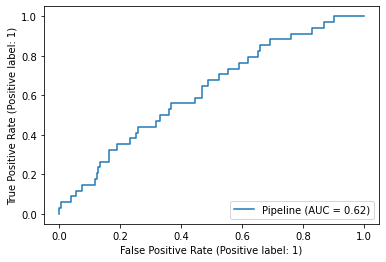

In [55]:
plot_roc_curve(logistic_model_ohe, X_test, y_test)

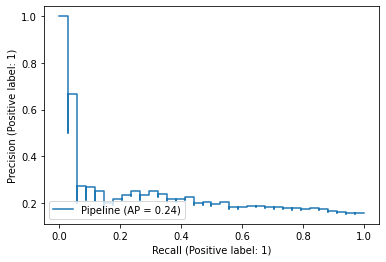

In [56]:
plot_precision_recall_curve(logistic_model_ohe, X_test, y_test)

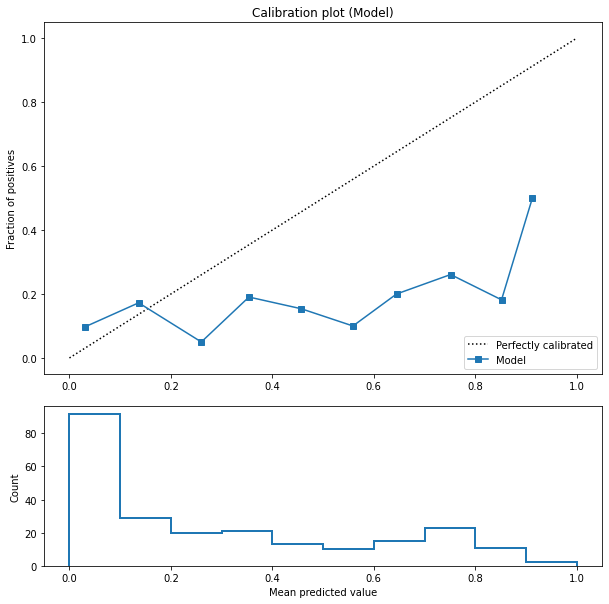

In [57]:
plot_calibration_curve("Model", 1, logistic_model_ohe.predict_proba(X_test)[:,1])

#### Random Forest with One Hot Encoding

In [58]:
params = { "n_estimators": 300,
           "max_depth": 10,
           "max_features": .4,
           "max_samples": 0.4 }

In [59]:
rf_model = RandomForestClassifier(**params)
rf_model_ohe=Pipeline(steps=[('preprocessor', preprocessor_ohe),
                      ('classifier', rf_model)])  

In [60]:
rf_model_ohe = run_model_experiment(rf_model_ohe,
                                X_train,
                                y_train,
                                X_test,
                                y_test,
                                config = params,
                                name = 'RFwithOHE',
                                tags = ['RF', 'OheEncoding'])

wandb: 
wandb: Plotting RFwithOHE.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


pr_auc,▁
roc_auc,▁
pr_auc,0.2074
roc_auc,0.6242


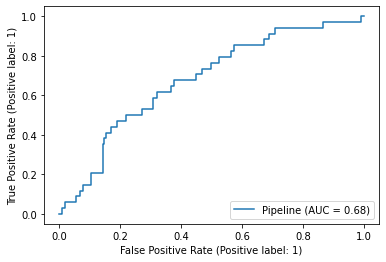

In [61]:
plot_roc_curve(rf_model_ohe, X_test, y_test)

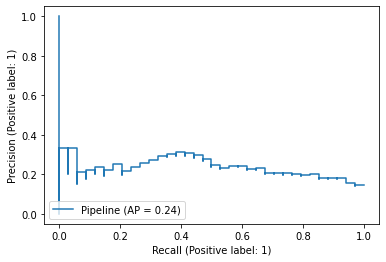

In [62]:
plot_precision_recall_curve(rf_model_ohe, X_test, y_test)

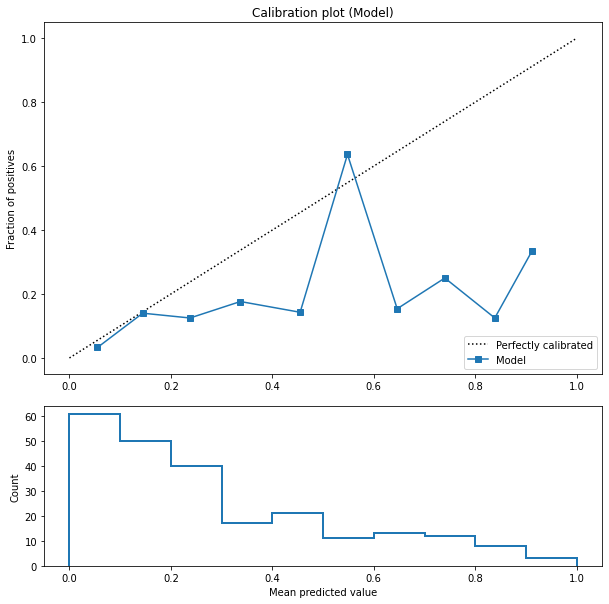

In [63]:
plot_calibration_curve("Model", 1, rf_model_ohe.predict_proba(X_test)[:,1])

#### Gradient Boosted Trees with OHE

In [64]:
params = { "n_estimators": 300,
           "max_depth": 6 }

In [65]:
gbm_model = GradientBoostingClassifier(**params)  
gbm_model_ohe=Pipeline(steps=[('preprocessor', preprocessor_ohe),
                      ('classifier', gbm_model)])  

In [66]:
gbm_model_ohe = run_model_experiment(gbm_model_ohe,
                                X_train,
                                 y_train,
                                 X_test,
                                 y_test,
                                 config = params,
                                 name = 'GBMwithOHEEncoding',
                                 tags = ['GBM', 'OheEncoding'])

wandb: 
wandb: Plotting GBMwithOHEEncoding.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


pr_auc,▁
roc_auc,▁
pr_auc,0.17711
roc_auc,0.57528


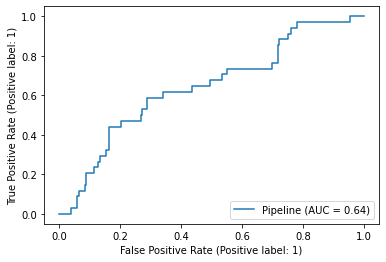

In [67]:
plot_roc_curve(gbm_model_ohe, X_test, y_test)

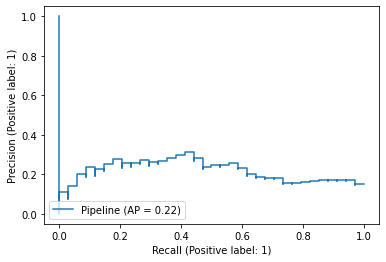

In [68]:
plot_precision_recall_curve(gbm_model_ohe, X_test, y_test)

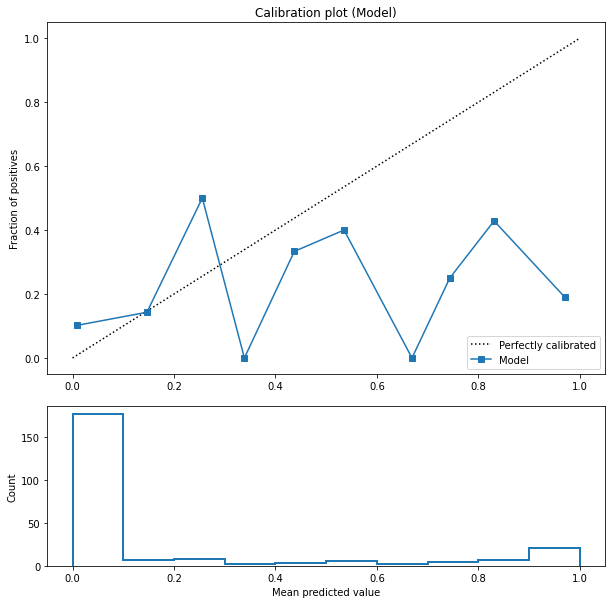

In [69]:
plot_calibration_curve("Model", 1, gbm_model_ohe.predict_proba(X_test)[:,1])

#### XGBoost model

In [70]:
params = { "n_estimators": 100,
           "max_depth": 6 }

In [71]:
xgb_classifier = XGBClassifier(**params)
xgb_classifier_ohe=Pipeline(steps=[('preprocessor', preprocessor_ohe),
                      ('classifier', xgb_classifier)]) 

In [72]:
xgb_classifier_ohe = run_model_experiment(xgb_classifier_ohe,
                                X_train,
                                y_train,
                                X_test,
                                y_test,
                                config = params,
                                name = 'XGBwithOHE',
                                tags = ['XGB', 'OheEncoding'])

wandb: 
wandb: Plotting XGBwithOHE.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


pr_auc,▁
roc_auc,▁
pr_auc,0.20458
roc_auc,0.61692


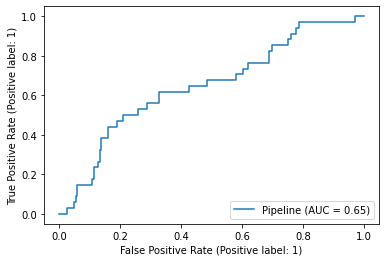

In [73]:
plot_roc_curve(xgb_classifier_ohe, X_test, y_test)

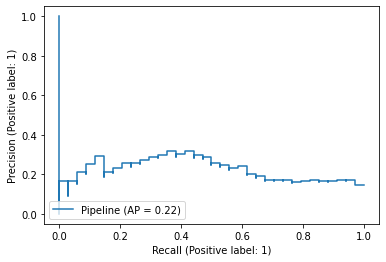

In [74]:
plot_precision_recall_curve(xgb_classifier_ohe, X_test, y_test)

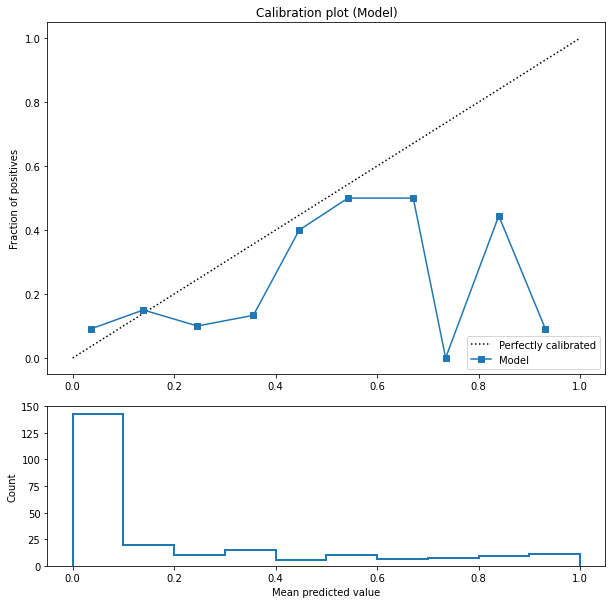

In [75]:
plot_calibration_curve("Model", 1, xgb_classifier_ohe.predict_proba(X_test)[:,1])

### Grid Search and Best Model Tracking

#### Gradient Boosted Trees with OHE

In [76]:
params = { "n_estimators": [100, 200, 300],
           "max_depth": [4, 6] }

gbm_cv = GridSearchCV(GradientBoostingClassifier(),
                      param_grid = params,
                      cv = 5,
                      scoring = 'roc_auc')  
gbm_cv_model=Pipeline(steps=[('preprocessor', preprocessor_ohe),
                      ('classifier', gbm_cv)])

gbm_cv_model.fit(X_train, y_train)         

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'YearsInCurrentRole',
                                                   'YearsAtCompany',
                                                   'MonthlyRate',
                                                   'TotalWorkingYears',
                                                   'YearsWithCurrManager']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BusinessTravel',
                                                   'Department', 'Education',
                          

In [77]:
gbm_cv.best_params_

{'max_depth': 6, 'n_estimators': 200}

#### Random Forest with One Hot Encoding

In [78]:
params = { "n_estimators": [100, 200, 300],
           "max_depth": [4, 6,10],
          "max_features": [.2,.4],
          "max_samples": [.2,.4]}

rf_cv = GridSearchCV(RandomForestClassifier(),
                      param_grid = params,
                      cv = 5,
                      scoring = 'roc_auc')  
rf_cv_model=Pipeline(steps=[('preprocessor', preprocessor_ohe),
                      ('classifier', rf_cv)])

rf_cv_model.fit(X_train, y_train)  

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'YearsInCurrentRole',
                                                   'YearsAtCompany',
                                                   'MonthlyRate',
                                                   'TotalWorkingYears',
                                                   'YearsWithCurrManager']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BusinessTravel',
                                                   'Department', 'Education',
                          

In [79]:
rf_cv.best_params_

{'max_depth': 10, 'max_features': 0.4, 'max_samples': 0.4, 'n_estimators': 300}

#### XGBoost with One Hot Encoding

In [80]:
params = { "n_estimators": [100, 200, 300],
           "max_depth": [4, 6] }

xgb_cv = GridSearchCV(XGBClassifier(),
                      param_grid = params,
                      cv = 5,
                      scoring = 'roc_auc')

xgb_cv_model=Pipeline(steps=[('preprocessor', preprocessor_ohe),
                      ('classifier', xgb_cv)])

xgb_cv_model.fit(X_train, y_train)  

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'YearsInCurrentRole',
                                                   'YearsAtCompany',
                                                   'MonthlyRate',
                                                   'TotalWorkingYears',
                                                   'YearsWithCurrManager']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BusinessTravel',
                                                   'Department', 'Education',
                          

In [81]:
xgb_cv.best_params_

{'max_depth': 6, 'n_estimators': 300}

### Model Building using Target Encoding

#### Baseline model: Logistic Regression with Target Encoding

In [82]:
logreg= LogisticRegression(random_state=42)
logistic_model_tarEnc=Pipeline(steps=[('preprocessor', preprocessor_tarEnc),
                      ('regressor', logreg)])  

logistic_model_tarEnc=run_model_experiment(logistic_model_tarEnc,
                                   X_train,
                                   y_train,
                                   X_test,
                                   y_test,
                                   name = 'LogisticRegressionWithtargetEnc',
                                   tags = ['Logistic Regression', 'baseline', 'TargetEncoder'])

wandb: 
wandb: Plotting LogisticRegressionWithtargetEnc.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


pr_auc,▁
roc_auc,▁
pr_auc,0.2028
roc_auc,0.63119


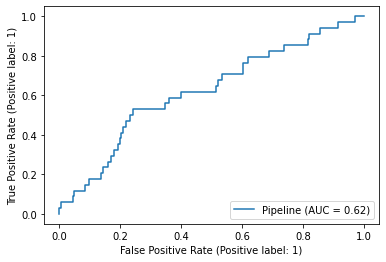

In [83]:
plot_roc_curve(logistic_model_tarEnc, X_test, y_test)

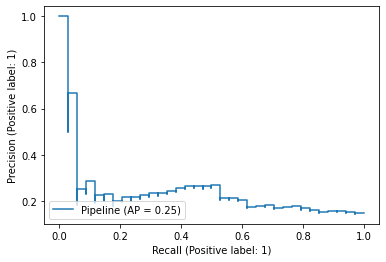

In [84]:
plot_precision_recall_curve(logistic_model_tarEnc, X_test, y_test)

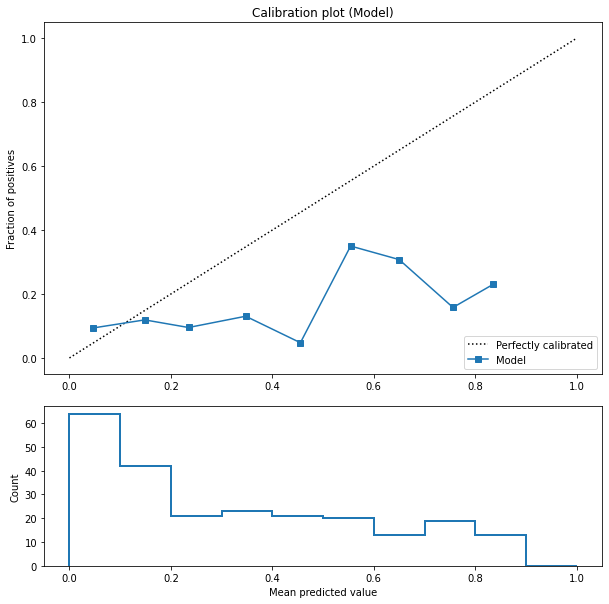

In [85]:
plot_calibration_curve("Model", 1, logistic_model_tarEnc.predict_proba(X_test)[:,1])

#### Random Forest with Target Encoding

In [86]:
params = { "n_estimators": 300,
           "max_depth": 10,
           "max_features": .2,
           "max_samples": 0.4 }

rf_model = RandomForestClassifier(**params)
rf_model_tarEnc=Pipeline(steps=[('preprocessor', preprocessor_tarEnc),
                      ('classifier', rf_model)])  

rf_model_tarEnc = run_model_experiment(rf_model_tarEnc,
                                X_train,
                                y_train,
                                X_test,
                                y_test,
                                config = params,
                                name = 'RFwithTargetEncoder',
                                tags = ['RF', 'TargetEncoder'])

wandb: 
wandb: Plotting RFwithTargetEncoder.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


pr_auc,▁
roc_auc,▁
pr_auc,0.20537
roc_auc,0.62653


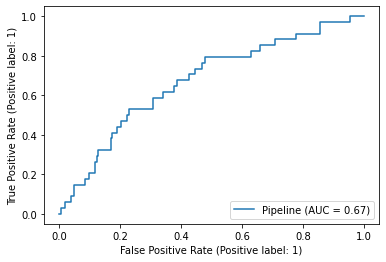

In [87]:
plot_roc_curve(rf_model_tarEnc, X_test, y_test)

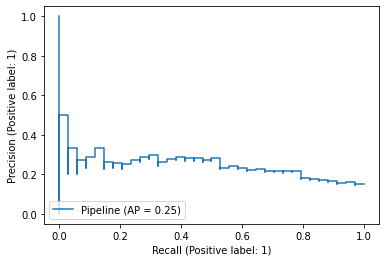

In [88]:
plot_precision_recall_curve(rf_model_tarEnc, X_test, y_test)

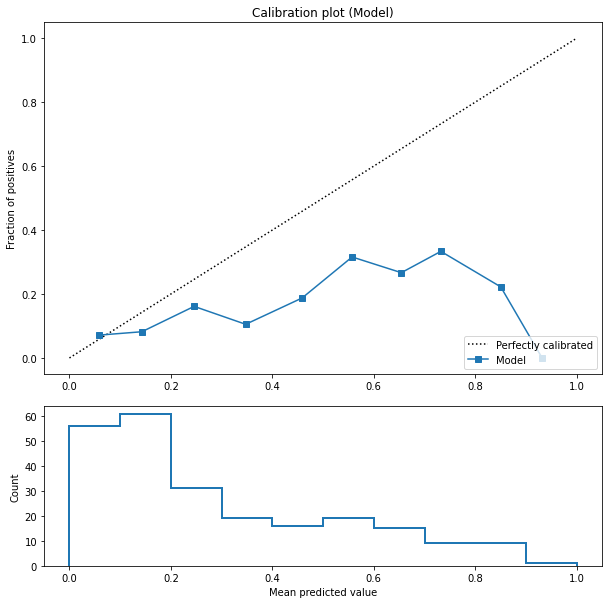

In [89]:
plot_calibration_curve("Model", 1, rf_model_tarEnc.predict_proba(X_test)[:,1])

#### Gradient Boosted Trees with TargetEncoding

In [90]:
params = { "n_estimators": 300,
           "max_depth": 6 }

gbm_model = GradientBoostingClassifier(**params)  
gbm_model_tarEnc=Pipeline(steps=[('preprocessor', preprocessor_tarEnc),
                      ('classifier', gbm_model)])  

gbm_model_tarEnc = run_model_experiment(gbm_model_tarEnc,
                                X_train,
                                 y_train,
                                 X_test,
                                 y_test,
                                 config = params,
                                 name = 'GBMwithTargetEncoder',
                                 tags = ['GBM', 'TargetEncoder'])

wandb: 
wandb: Plotting GBMwithTargetEncoder.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


pr_auc,▁
roc_auc,▁
pr_auc,0.18643
roc_auc,0.58998


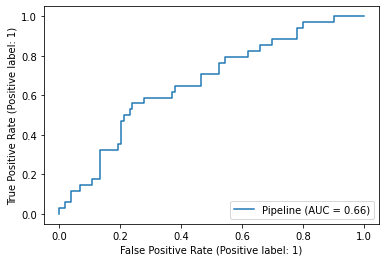

In [91]:
plot_roc_curve(gbm_model_tarEnc, X_test, y_test)

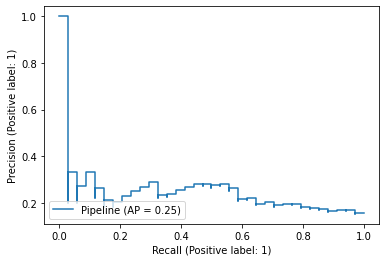

In [92]:
plot_precision_recall_curve(gbm_model_tarEnc, X_test, y_test)

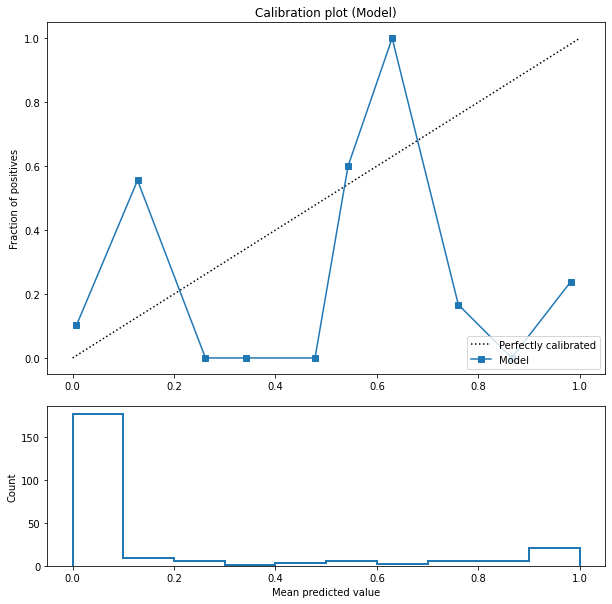

In [93]:
plot_calibration_curve("Model", 1, gbm_model_tarEnc.predict_proba(X_test)[:,1])

#### XGBoost model with TargetEncoding

In [94]:
params = { "n_estimators": 500,
           "max_depth": 6 }

xgb_classifier = XGBClassifier(**params)
xgb_classifier_model_tarEnc=Pipeline(steps=[('preprocessor', preprocessor_tarEnc),
                      ('classifier', xgb_classifier)]) 

xgb_classifier_model_tarEnc = run_model_experiment(xgb_classifier_model_tarEnc,
                                X_train,
                                y_train,
                                X_test,
                                y_test,
                                config = params,
                                name = 'XGBwithTargetEncoder',
                                tags = ['XGB', 'TargetEncoder'])


wandb: 
wandb: Plotting XGBwithTargetEncoder.
wandb: WARNING could not find any of attributes feature_importances_, feature_log_prob_, coef_ on classifier. Cannot plot feature importances.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


pr_auc,▁
roc_auc,▁
pr_auc,0.17343
roc_auc,0.57033


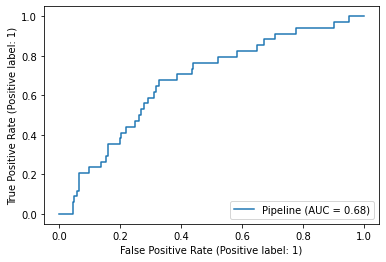

In [95]:
plot_roc_curve(xgb_classifier_model_tarEnc, X_test, y_test)

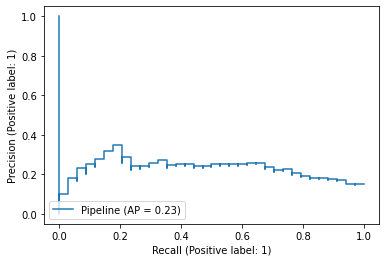

In [96]:
plot_precision_recall_curve(xgb_classifier_model_tarEnc, X_test, y_test)

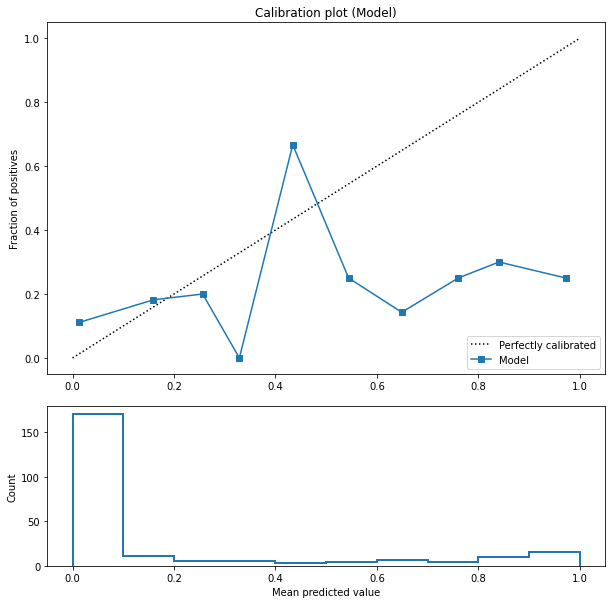

In [97]:
plot_calibration_curve("Model", 1, xgb_classifier_model_tarEnc.predict_proba(X_test)[:,1])

### Grid Search and Best Model Tracking

#### Gradient Boosted Trees with TargetEncoding

In [98]:
params = { "n_estimators": [100, 200, 300],
           "max_depth": [4, 6] }

gbm_cv = GridSearchCV(GradientBoostingClassifier(),
                      param_grid = params,
                      cv = 5,
                      scoring = 'roc_auc')  
gbm_cv_model=Pipeline(steps=[('preprocessor', preprocessor_tarEnc),
                      ('classifier', gbm_cv)])

gbm_cv_model.fit(X_train, y_train)         


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'YearsInCurrentRole',
                                                   'YearsAtCompany',
                                                   'MonthlyRate',
                                                   'TotalWorkingYears',
                                                   'YearsWithCurrManager']),
                                                 ('cat',
                                                  TargetEncoder(min_samples_leaf=100,
                                                                smoothing=1000.0),
                                                  ['BusinessTravel',
                         

In [99]:
gbm_cv.best_params_

{'max_depth': 6, 'n_estimators': 200}

#### Random Forest with Target Encoding

In [100]:
params = { "n_estimators": [100, 200, 300],
           "max_depth": [4, 6,10],
          "max_features": [.2,.4],
          "max_samples": [.2,.4]}

rf_cv = GridSearchCV(RandomForestClassifier(),
                      param_grid = params,
                      cv = 5,
                      scoring = 'roc_auc')  
rf_cv_model=Pipeline(steps=[('preprocessor', preprocessor_tarEnc),
                      ('classifier', rf_cv)])

rf_cv_model.fit(X_train, y_train)  

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'YearsInCurrentRole',
                                                   'YearsAtCompany',
                                                   'MonthlyRate',
                                                   'TotalWorkingYears',
                                                   'YearsWithCurrManager']),
                                                 ('cat',
                                                  TargetEncoder(min_samples_leaf=100,
                                                                smoothing=1000.0),
                                                  ['BusinessTravel',
                         

In [101]:
rf_cv.best_params_

{'max_depth': 10, 'max_features': 0.2, 'max_samples': 0.4, 'n_estimators': 300}

#### XGBoost with Target Encoding

In [102]:
params = { "n_estimators": [100, 200, 300],
           "max_depth": [4, 6] }

xgb_cv = GridSearchCV(XGBClassifier(),
                      param_grid = params,
                      cv = 5,
                      scoring = 'roc_auc')

xgb_cv_model=Pipeline(steps=[('preprocessor', preprocessor_tarEnc),
                      ('classifier', xgb_cv)])

xgb_cv_model.fit(X_train, y_train)  

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'YearsInCurrentRole',
                                                   'YearsAtCompany',
                                                   'MonthlyRate',
                                                   'TotalWorkingYears',
                                                   'YearsWithCurrManager']),
                                                 ('cat',
                                                  TargetEncoder(min_samples_leaf=100,
                                                                smoothing=1000.0),
                                                  ['BusinessTravel',
                         

In [103]:
xgb_cv.best_params_

{'max_depth': 6, 'n_estimators': 300}

#### Get Experiment Details

In [104]:
api = wandb.Api()

all_runs = api.runs("krishnak20/employee_attrition", order="+summary_metrics.roc_auc")

for run in all_runs:
  print(f"Model Name: {run.name} and ROC_AUC {run.summary.get('roc_auc')}")
  print(run.config)

Model Name: GBMwithTargetEncoder and ROC_AUC 0.523733255678509
{'max_depth': 6, 'n_estimators': 300}
Model Name: XGBwithTargetEncoder and ROC_AUC 0.523733255678509
{'max_depth': 6, 'n_estimators': 300}
Model Name: GBMwithTargetEncoder and ROC_AUC 0.5286837507280139
{'max_depth': 6, 'n_estimators': 300}
Model Name: XGBwithTargetEncoder and ROC_AUC 0.5384391380314503
{'max_depth': 6, 'n_estimators': 100}
Model Name: XGBwithTargetEncoder and ROC_AUC 0.5409143855562027
{'max_depth': 6, 'n_estimators': 500}
Model Name: XGBwithTargetEncoder and ROC_AUC 0.5409143855562027
{'max_depth': 6, 'n_estimators': 500}
Model Name: XGBwithTargetEncoder and ROC_AUC 0.5409143855562027
{'max_depth': 6, 'n_estimators': 500}
Model Name: GBMwithOHEEncoding and ROC_AUC 0.5483401281304601
{'max_depth': 6, 'n_estimators': 300}
Model Name: GBMwithOHEEncoding and ROC_AUC 0.5483401281304601
{'max_depth': 6, 'n_estimators': 300}
Model Name: GBMwithTargetEncoder and ROC_AUC 0.5556202679091439
{'max_depth': 6, 'n_esti

## Model Deployment

#### Creating the ONNX Graph

In [115]:
num_features=num_features

In [116]:
cat_features=cat_features

In [117]:

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer_ohe = OneHotEncoder(handle_unknown='ignore')
categorical_transformer_tarEnc = TargetEncoder(min_samples_leaf=100, smoothing=1000.0)

preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),                  
        ('cat', categorical_transformer_ohe, cat_features),
    ])

preprocessor_tarEnc = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),                  
        ('cat', categorical_transformer_tarEnc, cat_features),
    ])


In [118]:
params = { "n_estimators": 400,
           "max_depth": 4, 
         "objective": 'binary:logistic'}

xgb_classifier = XGBClassifier(**params)

clf = Pipeline(steps=[('preprocessor', preprocessor_ohe),
                      ('regressor', xgb_classifier)])           

clf.fit(X_train, 
        y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyIncome',
                                                   'YearsInCurrentRole',
                                                   'YearsAtCompany',
                                                   'MonthlyRate',
                                                   'TotalWorkingYears',
                                                   'YearsWithCurrManager']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BusinessTravel',
                                                   'Department', 'Education',
                          

In [119]:
!pip install onnx
!pip install pydot
!pip install skl2onnx
!pip install onnxruntime
!pip install onnxmltools


In [120]:
import skl2onnx
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
import onnxruntime as rt
from skl2onnx import convert_sklearn, __version__, update_registered_converter
from skl2onnx.common.data_types import FloatTensorType, StringTensorType
from skl2onnx.common.data_types import Int64TensorType
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost 
import pprint
import os


In [121]:
def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue
        if v == 'int64':
            t = FloatTensorType([None, 1])
        elif v == 'float64':
            t = FloatTensorType([None, 1])
        else:
            t = StringTensorType([None, 1])
        inputs.append((k, t))
    return inputs


inputs = convert_dataframe_schema(X_train)

pprint.pprint(inputs)

[('TotalWorkingYears', FloatTensorType(shape=[None, 1])),
 ('YearsWithCurrManager', FloatTensorType(shape=[None, 1])),
 ('YearsAtCompany', FloatTensorType(shape=[None, 1])),
 ('MonthlyRate', FloatTensorType(shape=[None, 1])),
 ('YearsInCurrentRole', FloatTensorType(shape=[None, 1])),
 ('MonthlyIncome', FloatTensorType(shape=[None, 1])),
 ('BusinessTravel', StringTensorType(shape=[None, 1])),
 ('Department', StringTensorType(shape=[None, 1])),
 ('Education', FloatTensorType(shape=[None, 1])),
 ('EducationField', StringTensorType(shape=[None, 1])),
 ('Gender', StringTensorType(shape=[None, 1])),
 ('JobRole', StringTensorType(shape=[None, 1])),
 ('MaritalStatus', StringTensorType(shape=[None, 1])),
 ('RelationshipSatisfaction', FloatTensorType(shape=[None, 1])),
 ('StockOptionLevel', FloatTensorType(shape=[None, 1]))]


In [122]:
update_registered_converter(
    XGBClassifier, 'XGBoostXGBClassifier',
    calculate_linear_classifier_output_shapes, convert_xgboost,
    options={'nocl': [True, False], 'zipmap': [True, False, 'columns']})

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
#import wandb
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer
import onnxruntime as rt
from skl2onnx import convert_sklearn, update_registered_converter
from skl2onnx.common.data_types import FloatTensorType, StringTensorType
from skl2onnx.common.data_types import Int64TensorType
from skl2onnx.common.shape_calculator import calculate_linear_classifier_output_shapes
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost  # noqa
import pprint
import os
import wandb
from xgboost import XGBClassifier
#from gradio import gradio as gr

warnings.filterwarnings("ignore")

#### Converting the pipeline to ONNX format

In [124]:
model_onnx = convert_sklearn(
    clf, 'pipeline_xgboost',
    inputs)

#### Storing the pipeline in a file

In [125]:
MODEL_DIR = "./employee_attrition"
MODEL_FILE_NAME = "employee_attrition_xgboost.onnx"

In [127]:
os.mkdir(MODEL_DIR)
# And save.
with open(MODEL_DIR + "/" + MODEL_FILE_NAME, "wb") as f:
    f.write(model_onnx.SerializeToString())

281256

#### Uploading the pipeline to weights and biases for tracking

In [150]:
os.environ["WANDB_API_KEY"] = "f18186cbea88a0af7b8845f2b0f9033603152679"

In [151]:
wandb.init(project='employee_attrition', 
           config=params, 
           tags = ['XGB', 'OHE'])

wandb.run.name = "XGBProdModel"

In [152]:
wandb.log( {"roc_auc" : roc_auc_score} )

In [154]:
model_artifact = wandb.Artifact("XGBoost_Employee_attrition",
                                type = 'model',
                                description = 'XGBoost Model for employee attrition prediction')

In [155]:
model_artifact.add_dir(MODEL_DIR)

wandb: Adding directory to artifact (./employee_attrition)... Done. 0.1s


In [156]:
wandb.run.log_artifact(model_artifact)

In [157]:
wandb.save()
wandb.finish()

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

roc_auc,sklearn.metrics._ran...


### Creating a web app to deploy the model

In [160]:
#!pip install onnxruntime
#!pip install -q gradio 

In [161]:
import onnxruntime as rt
from gradio import gradio as gr

#### Initialize Weights and Biases

In [162]:
os.environ["WANDB_API_KEY"] = "f18186cbea88a0af7b8845f2b0f9033603152679"

In [163]:
run = wandb.init(project='employee_attrition')

#### Download the model and load it

In [164]:
ARTIFACT_NAME = 'XGBoost_Employee_attrition:v4'

In [165]:
#run = wandb.init()
artifact = run.use_artifact('krishnak20/employee_attrition/' + ARTIFACT_NAME, type='model')
artifact_dir = artifact.download()

In [166]:
artifact_dir

'./artifacts/XGBoost_Employee_attrition:v4'

#### Implement the predict() function

In [168]:
def predict_attrition(Gender, TotalWorkingYears, YearsWithCurrManager, YearsAtCompany,
                     MonthlyRate, YearsInCurrentRole, MonthlyIncome, BusinessTravel, Department,
                      Education, EducationField, JobRole, MaritalStatus, RelationshipSatisfaction,
                      StockOptionLevel
                  ):

    inputs_dict = {'Gender' : Gender, 
              'TotalWorkingYears': float(TotalWorkingYears), 
              'YearsWithCurrManager': float(YearsWithCurrManager), 
              'YearsAtCompany': float(YearsAtCompany), 
              'MonthlyRate': float(MonthlyRate), 
              'YearsInCurrentRole': float(YearsInCurrentRole),
                   'MonthlyIncome': float(MonthlyIncome),
                   'BusinessTravel': BusinessTravel,
                   'Department': Department,
                   'Education': Education,
                   'EducationField': EducationField,
                   'JobRole': JobRole,
                   'MaritalStatus': MaritalStatus,
                   'RelationshipSatisfaction': RelationshipSatisfaction,
                   'StockOptionLevel': StockOptionLevel
                   
              }

    df = pd.DataFrame(inputs_dict, index = [0])
    print(df)

    inputs = {c: df[c].values for c in df.columns}
    for c in num_features:
        inputs[c] = inputs[c].astype(np.float32)
    for k in inputs:
        inputs[k] = inputs[k].reshape((inputs[k].shape[0], 1))            
  
    sess = rt.InferenceSession(artifact_dir + '/employee_attrition_xgboost.onnx')
    pred_onx = sess.run(None, inputs)

    predicted_attrition = float(pred_onx[0][0,0])
    return {f'Predicted probability of employee attrition: {np.round(predicted_attrition, 2)}' }

In [ ]:
X_train['StockOptionLevel'].value_counts()

### Implement UI

In [170]:

Gender = gr.inputs.Radio(['Male', 'Female'], default="Male", label="Gender")
MaritalStatus=gr.inputs.Radio(['Married', 'Single','Divorced'], default="Married", label="Marital Status")
TotalWorkingYears= gr.inputs.Slider(minimum=0, maximum=45, label="Work Experience (in years)")
YearsWithCurrManager= gr.inputs.Slider(minimum=0, maximum=20, label="Experience with Current Manager (in years)")
YearsAtCompany= gr.inputs.Slider(minimum=0, maximum=45, label="Years at Current company")
YearsInCurrentRole= gr.inputs.Slider(minimum=0, maximum=20, label="Years in Current Role")
MonthlyRate= gr.inputs.Slider(minimum=0, maximum=30000, label="Monthly salary (in Rs.)")
MonthlyIncome=gr.inputs.Slider(minimum=0, maximum=30000, label="Monthly income (in Rs.)")
BusinessTravel=gr.inputs.Radio(['Travel_Rarely', 'Travel_Frequently','Non-Travel'], default="Travel_Rarely", 
                               label="Business travel")
Department= gr.inputs.Radio(['Research & Development', 'Sales','Human Resources'], default="Research & Development", 
                            label="Department")
Education= gr.inputs.Radio(['1', '2','3','4','5'], default="3", label="Education Level (1-5)")
EducationField=gr.inputs.Radio(['Life Sciences', 'Medical','Technical Degree','Marketing','Human Resources','Other'], 
                               default="Life Sciences", label="Education Field")
JobRole= gr.inputs.Radio(['Sales Executive', 'Laboratory Technician','Research Scientist','Sales Representative',
                          'Manufacturing Director','Healthcare Representative','Manager','Research Director',
                          'Human Resources'], default="Sales Executive", label="JobRole")
RelationshipSatisfaction= gr.inputs.Radio(['1', '2','3','4'], default="3", 
                            label="Relationship Satisfaction(1-4)")
StockOptionLevel= gr.inputs.Radio(['0','1', '2','3'], default="0", 
                            label="Stock Option Level(0-3)")

gr.Interface(predict_attrition, [Gender, TotalWorkingYears, YearsWithCurrManager, YearsAtCompany,
                     MonthlyRate, YearsInCurrentRole, MonthlyIncome, BusinessTravel, Department,
                      Education, EducationField, JobRole, MaritalStatus, RelationshipSatisfaction,
                      StockOptionLevel], "text", live=False).launch(debug=True);
                 

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://38287.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


KeyboardInterrupt: ignored

### Model Monitoring

In [179]:
#!pip install evidently

#### Predicting on Production Set

In [171]:
hr_df_prod_X=hr_df_prod[selected_features]
hr_df_prod_X=hr_df_prod_X.reset_index(drop=True)

Error in callback <function _WandbInit._resume_backend at 0x7f6c50971cb0> (for pre_run_cell):


Exception: ignored

Error in callback <function _WandbInit._pause_backend at 0x7f6c50971c20> (for post_run_cell):


Exception: ignored

In [172]:
hr_df_prod['prediction'] = clf.predict(hr_df_prod_X)

Error in callback <function _WandbInit._resume_backend at 0x7f6c50971cb0> (for pre_run_cell):


Exception: ignored

Error in callback <function _WandbInit._pause_backend at 0x7f6c50971c20> (for post_run_cell):


Exception: ignored

In [173]:
hr_df_prod.shape

Error in callback <function _WandbInit._resume_backend at 0x7f6c50971cb0> (for pre_run_cell):


Exception: ignored

(294, 36)

Error in callback <function _WandbInit._pause_backend at 0x7f6c50971c20> (for post_run_cell):


Exception: ignored

#### Retriving the dummy variables from the pipeline

In [174]:
new_cat_features = list(clf['preprocessor'].transformers_[1][1].get_feature_names())

Error in callback <function _WandbInit._resume_backend at 0x7f6c50971cb0> (for pre_run_cell):


Exception: ignored

Error in callback <function _WandbInit._pause_backend at 0x7f6c50971c20> (for post_run_cell):


Exception: ignored

In [175]:
new_cat_features

Error in callback <function _WandbInit._resume_backend at 0x7f6c50971cb0> (for pre_run_cell):


Exception: ignored

['x0_Non-Travel',
 'x0_Travel_Frequently',
 'x0_Travel_Rarely',
 'x1_Human Resources',
 'x1_Research & Development',
 'x1_Sales',
 'x2_1',
 'x2_2',
 'x2_3',
 'x2_4',
 'x2_5',
 'x3_Human Resources',
 'x3_Life Sciences',
 'x3_Marketing',
 'x3_Medical',
 'x3_Other',
 'x3_Technical Degree',
 'x4_Female',
 'x4_Male',
 'x5_Healthcare Representative',
 'x5_Human Resources',
 'x5_Laboratory Technician',
 'x5_Manager',
 'x5_Manufacturing Director',
 'x5_Research Director',
 'x5_Research Scientist',
 'x5_Sales Executive',
 'x5_Sales Representative',
 'x6_Divorced',
 'x6_Married',
 'x6_Single',
 'x7_1',
 'x7_2',
 'x7_3',
 'x7_4',
 'x8_0',
 'x8_1',
 'x8_2',
 'x8_3']

Error in callback <function _WandbInit._pause_backend at 0x7f6c50971c20> (for post_run_cell):


Exception: ignored

In [176]:
len(num_features + new_cat_features)

Error in callback <function _WandbInit._resume_backend at 0x7f6c50971cb0> (for pre_run_cell):


Exception: ignored

45

Error in callback <function _WandbInit._pause_backend at 0x7f6c50971c20> (for post_run_cell):


Exception: ignored

In [177]:
hr_df_prod.drop('prediction',1).shape

Error in callback <function _WandbInit._resume_backend at 0x7f6c50971cb0> (for pre_run_cell):


Exception: ignored

(294, 35)

Error in callback <function _WandbInit._pause_backend at 0x7f6c50971c20> (for post_run_cell):


Exception: ignored

In [178]:
hr_df_prod.shape

Error in callback <function _WandbInit._resume_backend at 0x7f6c50971cb0> (for pre_run_cell):


Exception: ignored

(294, 36)

Error in callback <function _WandbInit._pause_backend at 0x7f6c50971c20> (for post_run_cell):


Exception: ignored

### Prepare Production Data

In [179]:
hr_df_prod_x_cols = clf.named_steps['preprocessor'].transform(hr_df_prod_X)
hr_df_prod_x_cols_df = pd.DataFrame( hr_df_prod_x_cols, columns  = num_features + new_cat_features)
hr_df_prod_x_cols_df_final = pd.concat([hr_df_prod[num_features].reset_index(drop=True), hr_df_prod_x_cols_df[new_cat_features]], axis = 1)
hr_df_prod_x_cols_df_final['prediction'] = clf.predict(hr_df_prod_X)
hr_df_prod_x_cols_df_final

Error in callback <function _WandbInit._resume_backend at 0x7f6c50971cb0> (for pre_run_cell):


Exception: ignored

,MonthlyIncome,YearsInCurrentRole,YearsAtCompany,MonthlyRate,TotalWorkingYears,YearsWithCurrManager,x0_Non-Travel,x0_Travel_Frequently,x0_Travel_Rarely,x1_Human Resources,x1_Research & Development,x1_Sales,x2_1,x2_2,x2_3,x2_4,x2_5,x3_Human Resources,x3_Life Sciences,x3_Marketing,x3_Medical,x3_Other,x3_Technical Degree,x4_Female,x4_Male,x5_Healthcare Representative,x5_Human Resources,x5_Laboratory Technician,x5_Manager,x5_Manufacturing Director,x5_Research Director,x5_Research Scientist,x5_Sales Executive,x5_Sales Representative,x6_Divorced,x6_Married,x6_Single,x7_1,x7_2,x7_3,x7_4,x8_0,x8_1,x8_2,x8_3,prediction
0,8463,4,5,23490,6,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1
1,4450,2,4,26250,5,3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,1555,0,1,11585,1,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
3,9724,0,1,18787,25,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
4,5914,11,13,9945,16,7,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1
5,2579,2,8,2912,8,6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
6,4230,4,5,19225,6,3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
7,2232,2,3,15417,7,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0
8,8865,7,19,16840,23,8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
9,2269,0,1,4892,1,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1


Error in callback <function _WandbInit._pause_backend at 0x7f6c50971c20> (for post_run_cell):


Exception: ignored

### Preparing the training data

In [189]:
X_train_new = X_train.reset_index()
X_train_x_cols = clf.named_steps['preprocessor'].transform(X_train_new)
X_train_x_cols_df = pd.DataFrame( X_train_x_cols, columns  = num_features + new_cat_features)
X_train_x_cols_df_final = pd.concat([X_train_new[num_features], X_train_x_cols_df[new_cat_features]], axis = 1)
X_train_x_cols_df_final['prediction'] = clf.predict(X_train[selected_features])
X_train_x_cols_df_final['Attrition'] = np.array(y_train)
X_train_x_cols_df_final

,MonthlyIncome,YearsInCurrentRole,YearsAtCompany,MonthlyRate,TotalWorkingYears,YearsWithCurrManager,x0_Non-Travel,x0_Travel_Frequently,x0_Travel_Rarely,x1_Human Resources,x1_Research & Development,x1_Sales,x2_1,x2_2,x2_3,x2_4,x2_5,x3_Human Resources,x3_Life Sciences,x3_Marketing,x3_Medical,x3_Other,x3_Technical Degree,x4_Female,x4_Male,x5_Healthcare Representative,x5_Human Resources,x5_Laboratory Technician,x5_Manager,x5_Manufacturing Director,x5_Research Director,x5_Research Scientist,x5_Sales Executive,x5_Sales Representative,x6_Divorced,x6_Married,x6_Single,x7_1,x7_2,x7_3,x7_4,x8_0,x8_1,x8_2,x8_3,prediction,Attrition
0,2439,0,1,14753,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1
1,2778,7,7,17725,10,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,1
2,2546,2,2,18300,6,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1
3,4787,2,2,26124,4,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1
4,2561,0,0,5355,8,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,2830,0,1,19810,2,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,1
1548,2101,0,1,3335,17,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1
1549,2329,0,1,23229,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,1
1550,10350,5,13,5586,15,5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,1


### Creating Data Drift Report

In [204]:
from evidently.dashboard import Dashboard
from evidently.tabs import DataDriftTab, NumTargetDriftTab
from evidently.pipeline.column_mapping import ColumnMapping

from evidently.model_profile import Profile
from evidently.profile_sections import DataDriftProfileSection

TypeError: ignored

In [198]:
column_mapping = ColumnMapping()

column_mapping.target = 'Attrition'
column_mapping.prediction = 'prediction'
column_mapping.datetime = None

column_mapping.numerical_features = num_features
column_mapping.categorical_features = new_cat_features

In [199]:
column_mapping

ColumnMapping(target='Attrition', prediction='prediction', datetime=None, id=None, numerical_features=['MonthlyIncome', 'YearsInCurrentRole', 'YearsAtCompany', 'MonthlyRate', 'TotalWorkingYears', 'YearsWithCurrManager'], categorical_features=['x0_Non-Travel', 'x0_Travel_Frequently', 'x0_Travel_Rarely', 'x1_Human Resources', 'x1_Research & Development', 'x1_Sales', 'x2_1', 'x2_2', 'x2_3', 'x2_4', 'x2_5', 'x3_Human Resources', 'x3_Life Sciences', 'x3_Marketing', 'x3_Medical', 'x3_Other', 'x3_Technical Degree', 'x4_Female', 'x4_Male', 'x5_Healthcare Representative', 'x5_Human Resources', 'x5_Laboratory Technician', 'x5_Manager', 'x5_Manufacturing Director', 'x5_Research Director', 'x5_Research Scientist', 'x5_Sales Executive', 'x5_Sales Representative', 'x6_Divorced', 'x6_Married', 'x6_Single', 'x7_1', 'x7_2', 'x7_3', 'x7_4', 'x8_0', 'x8_1', 'x8_2', 'x8_3'], target_names=None)

In [200]:
hr_data_drift_dashboard = Dashboard(tabs=[DataDriftTab()])
hr_data_drift_dashboard.calculate(X_train_x_cols_df_final, 
                                    hr_df_prod_x_cols_df_final, 
                                    column_mapping = column_mapping)

NameError: ignored

In [205]:
hr_data_drift_dashboard.save("newreports/hr_datadriftV1.html")

NameError: ignored

In [206]:
hr_data_drift_profile = Profile(sections=[DataDriftProfileSection()])
hr_data_drift_profile.calculate(X_train_x_cols_df_final, 
                                  hr_df_prod_x_cols_df_final, 
                                  column_mapping = column_mapping)
hr_data_drift_profile.json()

'{"data_drift": {"name": "data_drift", "datetime": "2021-12-07 23:28:13.277907", "data": {"utility_columns": {"date": null, "id": null, "target": "Attrition", "prediction": "prediction"}, "cat_feature_names": ["x0_Non-Travel", "x0_Travel_Frequently", "x0_Travel_Rarely", "x1_Human Resources", "x1_Research & Development", "x1_Sales", "x2_1", "x2_2", "x2_3", "x2_4", "x2_5", "x3_Human Resources", "x3_Life Sciences", "x3_Marketing", "x3_Medical", "x3_Other", "x3_Technical Degree", "x4_Female", "x4_Male", "x5_Healthcare Representative", "x5_Human Resources", "x5_Laboratory Technician", "x5_Manager", "x5_Manufacturing Director", "x5_Research Director", "x5_Research Scientist", "x5_Sales Executive", "x5_Sales Representative", "x6_Divorced", "x6_Married", "x6_Single", "x7_1", "x7_2", "x7_3", "x7_4", "x8_0", "x8_1", "x8_2", "x8_3"], "num_feature_names": ["MonthlyIncome", "YearsInCurrentRole", "YearsAtCompany", "MonthlyRate", "TotalWorkingYears", "YearsWithCurrManager"], "target_names": null, "op

### Generating Classification Performance Report

In [207]:
hr_df_prod_x_cols_df_final['Attrition'] = hr_df_prod['Attrition']

In [208]:
from evidently.tabs import RegressionPerformanceTab

TypeError: ignored

In [ ]:
dashboard = Dashboard(tabs=[RegressionPerformanceTab()])

In [ ]:
dashboard.calculate(X_train_x_cols_df_final, 
                    hr_df_prod_x_cols_df_final, 
                    column_mapping=column_mapping)

In [ ]:
dashboard.save("newreports/hr_dataPerormanceV1.html")

### Comparing Errors by Segments

In [209]:
hr_df_prod['prediction'] = clf.predict(hr_df_prod_X)


In [210]:
X_train['prediction'] = clf.predict(X_train[selected_features])
X_train['Attrition'] = np.array(y_train)

In [211]:
hr_df_prod=hr_df_prod.reset_index(drop=True)

In [212]:
hr_df_prod['error'] = hr_df_prod['Attrition'] - hr_df_prod['prediction']
X_train['error'] = X_train['Attrition'] - X_train['prediction']

#### Drift by Job Role

In [213]:
hr_job_role = list(hr_df_prod.JobRole.unique())

In [214]:
hr_job_role

['Sales Executive',
 'Manufacturing Director',
 'Human Resources',
 'Research Scientist',
 'Laboratory Technician',
 'Sales Representative',
 'Healthcare Representative',
 'Manager',
 'Research Director']

In [215]:
hr_df_prod.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,prediction,error
0,28,0,Travel_Rarely,866,Sales,5,3,Medical,1,1469,4,Male,84,3,2,Sales Executive,1,Single,8463,23490,0,Y,No,18,3,4,80,0,6,4,3,5,4,1,3,1,-1
1,53,0,Travel_Rarely,1084,Research & Development,13,2,Medical,1,250,4,Female,57,4,2,Manufacturing Director,1,Divorced,4450,26250,1,Y,No,11,3,3,80,2,5,3,3,4,2,1,3,0,0
2,24,1,Travel_Rarely,240,Human Resources,22,1,Human Resources,1,1714,4,Male,58,1,1,Human Resources,3,Married,1555,11585,1,Y,No,11,3,3,80,1,1,2,3,1,0,0,0,0,1
3,45,0,Travel_Rarely,1339,Research & Development,7,3,Life Sciences,1,86,2,Male,59,3,3,Research Scientist,1,Divorced,9724,18787,2,Y,No,17,3,3,80,1,25,2,3,1,0,0,0,0,0
4,36,0,Travel_Rarely,1396,Research & Development,5,2,Life Sciences,1,304,4,Male,62,3,2,Laboratory Technician,2,Single,5914,9945,8,Y,No,16,3,4,80,0,16,3,4,13,11,3,7,1,-1


In [216]:
hr_df_prod.groupby(['JobRole']).sum()['error']

JobRole
Healthcare Representative    4
Human Resources              1
Laboratory Technician       -8
Manager                      0
Manufacturing Director       3
Research Director            0
Research Scientist          -8
Sales Executive             -5
Sales Representative         1
Name: error, dtype: int64

#### Drift by Gender

In [217]:
hr_gender = list(hr_df_prod.Gender.unique())

In [218]:
hr_gender

['Male', 'Female']

In [219]:
hr_df_prod.groupby(['Gender']).sum()['error']

Gender
Female     3
Male     -15
Name: error, dtype: int64

#### Drift by Marital Status

In [220]:
hr_marital_status = list(hr_df_prod.MaritalStatus.unique())

In [221]:
hr_marital_status

['Single', 'Divorced', 'Married']

In [222]:
hr_df_prod.groupby(['MaritalStatus']).sum()['error']

MaritalStatus
Divorced     5
Married      3
Single     -20
Name: error, dtype: int64

#### Drift by Department

In [223]:
hr_department = list(hr_df_prod.Department.unique())

In [224]:
hr_department

['Sales', 'Research & Development', 'Human Resources']

In [225]:
hr_df_prod.groupby(['Department']).sum()['error']

Department
Human Resources           1
Research & Development   -9
Sales                    -4
Name: error, dtype: int64

## Model Explanation

In [226]:
#pip install eli5

In [227]:
import eli5.sklearn

In [228]:
X_features= list(X_train_x_cols_df_final.drop(['prediction','Attrition'], axis=1).columns)

In [229]:
eli5.explain_weights( 
    xgb_classifier, 
    feature_names = X_features )

Weight,Feature
0.1647,x8_0
0.0656,x5_Sales Executive
0.0480,x0_Non-Travel
0.0466,x5_Manufacturing Director
0.0388,x5_Healthcare Representative
0.0376,x5_Laboratory Technician
0.0336,x5_Research Director
0.0303,x2_1
0.0280,x0_Travel_Frequently
0.0265,x6_Divorced


#### Explaining the weights for a NO Attrition

In [230]:
X_train_new = X_train.reset_index()
X_train_x_cols = clf.named_steps['preprocessor'].transform(X_train_new)
X_train_x_cols_df = pd.DataFrame( X_train_x_cols, columns  = num_features + new_cat_features)
X_train_x_cols_df_final = pd.concat([X_train_new[num_features], X_train_x_cols_df[new_cat_features]], axis = 1)
X_train_x_cols_df_final

,MonthlyIncome,YearsInCurrentRole,YearsAtCompany,MonthlyRate,TotalWorkingYears,YearsWithCurrManager,x0_Non-Travel,x0_Travel_Frequently,x0_Travel_Rarely,x1_Human Resources,x1_Research & Development,x1_Sales,x2_1,x2_2,x2_3,x2_4,x2_5,x3_Human Resources,x3_Life Sciences,x3_Marketing,x3_Medical,x3_Other,x3_Technical Degree,x4_Female,x4_Male,x5_Healthcare Representative,x5_Human Resources,x5_Laboratory Technician,x5_Manager,x5_Manufacturing Director,x5_Research Director,x5_Research Scientist,x5_Sales Executive,x5_Sales Representative,x6_Divorced,x6_Married,x6_Single,x7_1,x7_2,x7_3,x7_4,x8_0,x8_1,x8_2,x8_3
0,2439,0,1,14753,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2778,7,7,17725,10,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2546,2,2,18300,6,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4787,2,2,26124,4,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2561,0,0,5355,8,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,2830,0,1,19810,2,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1548,2101,0,1,3335,17,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1549,2329,0,1,23229,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1550,10350,5,13,5586,15,5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [231]:
params = { "n_estimators": 400,
           "max_depth": 4, 
         "objective": 'binary:logistic'}

xgb_classifier_final = XGBClassifier(**params)           

xgb_classifier_final.fit(X_train_x_cols_df_final, 
        y_train)

XGBClassifier(max_depth=4, n_estimators=400)

In [232]:
X_test_new = X_train.reset_index()
X_test_x_cols = clf.named_steps['preprocessor'].transform(X_test_new)
X_test_x_cols_df = pd.DataFrame( X_test_x_cols, columns  = num_features + new_cat_features)
X_test_x_cols_df_final = pd.concat([X_train_new[num_features], X_test_x_cols_df[new_cat_features]], axis = 1)
X_test_x_cols_df_final

,MonthlyIncome,YearsInCurrentRole,YearsAtCompany,MonthlyRate,TotalWorkingYears,YearsWithCurrManager,x0_Non-Travel,x0_Travel_Frequently,x0_Travel_Rarely,x1_Human Resources,x1_Research & Development,x1_Sales,x2_1,x2_2,x2_3,x2_4,x2_5,x3_Human Resources,x3_Life Sciences,x3_Marketing,x3_Medical,x3_Other,x3_Technical Degree,x4_Female,x4_Male,x5_Healthcare Representative,x5_Human Resources,x5_Laboratory Technician,x5_Manager,x5_Manufacturing Director,x5_Research Director,x5_Research Scientist,x5_Sales Executive,x5_Sales Representative,x6_Divorced,x6_Married,x6_Single,x7_1,x7_2,x7_3,x7_4,x8_0,x8_1,x8_2,x8_3
0,2439,0,1,14753,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2778,7,7,17725,10,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,2546,2,2,18300,6,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4787,2,2,26124,4,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2561,0,0,5355,8,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,2830,0,1,19810,2,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1548,2101,0,1,3335,17,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1549,2329,0,1,23229,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1550,10350,5,13,5586,15,5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [233]:
X_test_x_cols_df_final.iloc[0]

MonthlyIncome                    2439.0
YearsInCurrentRole                  0.0
YearsAtCompany                      1.0
MonthlyRate                     14753.0
TotalWorkingYears                   1.0
YearsWithCurrManager                0.0
x0_Non-Travel                       0.0
x0_Travel_Frequently                1.0
x0_Travel_Rarely                    0.0
x1_Human Resources                  0.0
x1_Research & Development           1.0
x1_Sales                            0.0
x2_1                                0.0
x2_2                                1.0
x2_3                                0.0
x2_4                                0.0
x2_5                                0.0
x3_Human Resources                  0.0
x3_Life Sciences                    1.0
x3_Marketing                        0.0
x3_Medical                          0.0
x3_Other                            0.0
x3_Technical Degree                 0.0
x4_Female                           0.0
x4_Male                             1.0


In [234]:
y_test.iloc[0]

0

In [235]:
eli5.explain_prediction( xgb_classifier_final,
                         X_test_x_cols_df_final.iloc[0],
                         target_names = ['No Attrition', 'Attriton'] )

Explanation(estimator='XGBClassifier(max_depth=4, n_estimators=400)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target='Attriton', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='MonthlyRate', weight=1.1760385048121926, std=None, value=14753.0), FeatureWeight(feature='YearsInCurrentRole', weight=1.0394263378523585, std=None, value=0.0), FeatureWeight(feature='x8_0', weight=0.9635726768953107, std=None, value=1.0), FeatureWeight(feature='x0_Travel_Frequently', weight=0.912690920536567, std=None, value=1.0), FeatureWeight(feature='MonthlyIncome', weight=0.7776647588401672, std=None, value=2439.0), FeatureWeight(feature='YearsWithCurrManager', weight=0.6540033712345118, std=None, value=0.0), FeatureWeight(feature='x4_Female', weight=0.5512226767690924, std=None, value=0.0), FeatureWeight(feature='x2_2', weight=0.38493129684937005, std=None, value=1.0), FeatureWeight(feature='TotalWorkingYears', weight=0.287989647584997, std=None, value=1.0), FeatureWeight(feature='x7_4', weight=0.2856344535249549, std=None, value=0.0), FeatureWeight(feature='YearsAtCompany', weight=0.24890228266651096, std=None, value=1.0), FeatureWeight(feature='x6_Married', weight=0.21647984546936708, std=None, value=0.0), FeatureWeight(feature='x2_1', weight=0.0965335197223808, std=None, value=0.0), FeatureWeight(feature='x0_Travel_Rarely', weight=0.08523494746907802, std=None, value=0.0), FeatureWeight(feature='x0_Non-Travel', weight=0.0844171159573411, std=None, value=0.0), FeatureWeight(feature='x1_Research & Development', weight=0.07186914861359912, std=None, value=1.0), FeatureWeight(feature='x5_Healthcare Representative', weight=0.07046106061581707, std=None, value=0.0), FeatureWeight(feature='x5_Manufacturing Director', weight=0.06416131908751739, std=None, value=0.0), FeatureWeight(feature='x1_Human Resources', weight=0.04276547002663653, std=None, value=0.0), FeatureWeight(feature='x3_Other', weight=0.0299872078021038, std=None, value=0.0), FeatureWeight(feature='x8_1', weight=0.028266045798785118, std=None, value=0.0), FeatureWeight(feature='x8_2', weight=0.02370174536526983, std=None, value=0.0), FeatureWeight(feature='x5_Research Director', weight=0.02340253616249349, std=None, value=0.0), FeatureWeight(feature='x6_Divorced', weight=0.020147339356539617, std=None, value=0.0), FeatureWeight(feature='x2_5', weight=0.01653836388521593, std=None, value=0.0), FeatureWeight(feature='x3_Medical', weight=0.010218745840518096, std=None, value=0.0), FeatureWeight(feature='x5_Manager', weight=0.006364796910001533, std=None, value=0.0), FeatureWeight(feature='x8_3', weight=0.005093562144448716, std=None, value=0.0), FeatureWeight(feature='x3_Marketing', weight=0.0030532007950068046, std=None, value=0.0), FeatureWeight(feature='x7_1', weight=0.0023717875662115397, std=None, value=0.0)], neg=[FeatureWeight(feature='x

#### Explaining the weights for a Attrition person

In [236]:
X_test_x_cols_df_final.iloc[2]

MonthlyIncome                    2546.0
YearsInCurrentRole                  2.0
YearsAtCompany                      2.0
MonthlyRate                     18300.0
TotalWorkingYears                   6.0
YearsWithCurrManager                1.0
x0_Non-Travel                       0.0
x0_Travel_Frequently                0.0
x0_Travel_Rarely                    1.0
x1_Human Resources                  0.0
x1_Research & Development           1.0
x1_Sales                            0.0
x2_1                                0.0
x2_2                                0.0
x2_3                                0.0
x2_4                                0.0
x2_5                                1.0
x3_Human Resources                  0.0
x3_Life Sciences                    0.0
x3_Marketing                        0.0
x3_Medical                          0.0
x3_Other                            0.0
x3_Technical Degree                 1.0
x4_Female                           1.0
x4_Male                             0.0


In [237]:
y_test.iloc[2]

1

In [238]:
eli5.explain_prediction( xgb_classifier_final,
                         X_test_x_cols_df_final.iloc[2],
                         target_names = ['No Attrition', 'Attriton'] )

Explanation(estimator='XGBClassifier(max_depth=4, n_estimators=400)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target='Attriton', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='MonthlyRate', weight=1.1940928987596624, std=None, value=18300.0), FeatureWeight(feature='x8_0', weight=0.8990766216338798, std=None, value=1.0), FeatureWeight(feature='YearsAtCompany', weight=0.7406129726033153, std=None, value=2.0), FeatureWeight(feature='YearsWithCurrManager', weight=0.6331117302797504, std=None, value=1.0), FeatureWeight(feature='MonthlyIncome', weight=0.6033260249103147, std=None, value=2546.0), FeatureWeight(feature='x7_4', weight=0.4387765242153124, std=None, value=0.0), FeatureWeight(feature='x3_Technical Degree', weight=0.18386237650695123, std=None, value=1.0), FeatureWeight(feature='x0_Non-Travel', weight=0.081558994511608, std=None, value=0.0), FeatureWeight(feature='x2_1', weight=0.07065026660697939, std=None, value=0.0), FeatureWeight(feature='x5_Healthcare Representative', weight=0.058873697592455566, std=None, value=0.0), FeatureWeight(feature='YearsInCurrentRole', weight=0.050450083890408906, std=None, value=2.0), FeatureWeight(feature='x5_Manufacturing Director', weight=0.04569060317580088, std=None, value=0.0), FeatureWeight(feature='x6_Single', weight=0.043120235769500914, std=None, value=0.0), FeatureWeight(feature='TotalWorkingYears', weight=0.04267872858090461, std=None, value=6.0), FeatureWeight(feature='x1_Research & Development', weight=0.0375714376324708, std=None, value=1.0), FeatureWeight(feature='x8_2', weight=0.02927235054015899, std=None, value=0.0), FeatureWeight(feature='x3_Other', weight=0.023924790804079353, std=None, value=0.0), FeatureWeight(feature='x5_Research Director', weight=0.02340253616249349, std=None, value=0.0), FeatureWeight(feature='x6_Divorced', weight=0.018037948529840798, std=None, value=0.0), FeatureWeight(feature='x1_Human Resources', weight=0.016387240149561895, std=None, value=0.0), FeatureWeight(feature='x3_Marketing', weight=0.013178236769556019, std=None, value=0.0), FeatureWeight(feature='x5_Manager', weight=0.006364796910001533, std=None, value=0.0)], neg=[FeatureWeight(feature='x2_5', weight=-1.2217267996821415, std=None, value=1.0), FeatureWeight(feature='x4_Female', weight=-0.6781182139824683, std=None, value=1.0), FeatureWeight(feature='x7_2', weight=-0.3861356391128894, std=None, value=1.0), FeatureWeight(feature='x7_3', weight=-0.3812353795031857, std=None, value=0.0), FeatureWeight(feature='x6_Married', weight=-0.2966343329717734, std=None, value=1.0), FeatureWeight(feature='x5_Research Scientist', weight=-0.22831707919390112, std=None, value=1.0), FeatureWeight(feature='x7_1', weight=-0.15981163389232006, std=None, value=0.0), FeatureWeight(feature='x5_Laboratory Technician', weight=-0.14922306776043, std=None, value=0.0

### Partial Dependece Plots (PDPs)

In [239]:
from sklearn.inspection import PartialDependenceDisplay

#### Effect of MonthlyRate on Attrition

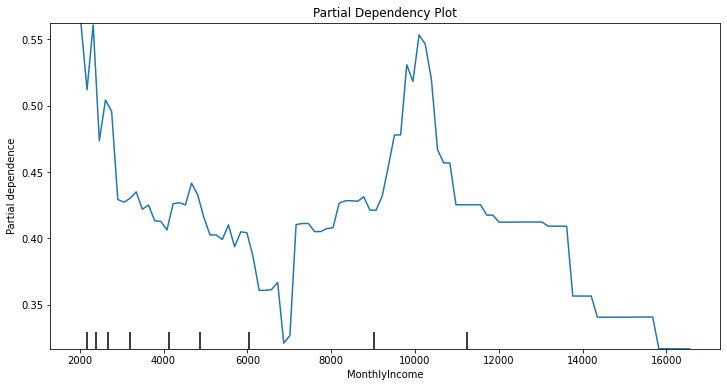

In [240]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Partial Dependency Plot")
PartialDependenceDisplay.from_estimator(xgb_classifier_final,
                                        X_test_x_cols_df_final,
                                        features = ['MonthlyIncome'],
                                        feature_names = X_features,
                                        ax = ax);

#### Effect of YearsAtCompany on Attrition

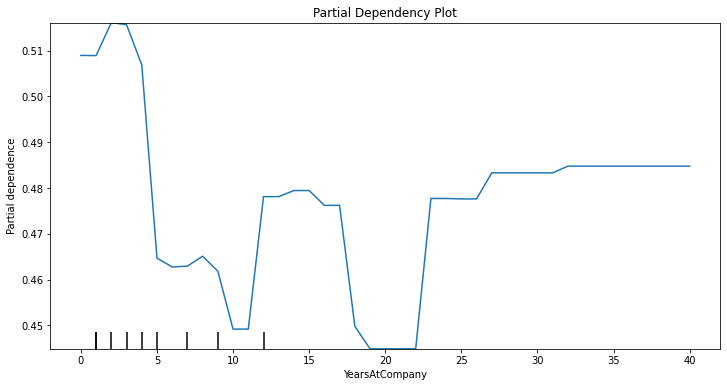

In [241]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Partial Dependency Plot")
PartialDependenceDisplay.from_estimator(xgb_classifier_final,
                                        X_test_x_cols_df_final,
                                        features = ['YearsAtCompany'],
                                        feature_names = X_features,
                                        ax = ax);

####  Effect of YearsInCurrentRole on Attrition

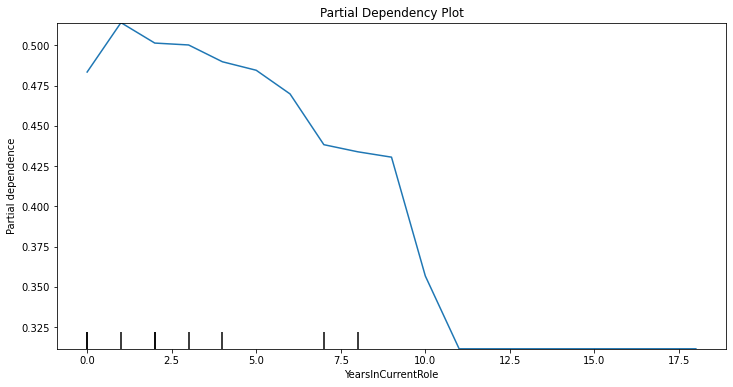

In [242]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Partial Dependency Plot")
PartialDependenceDisplay.from_estimator(xgb_classifier_final,
                                        X_test_x_cols_df_final,
                                        features = ['YearsInCurrentRole'],
                                        feature_names = X_features,
                                        ax = ax);

#### Effect of x6_Single on Attrition

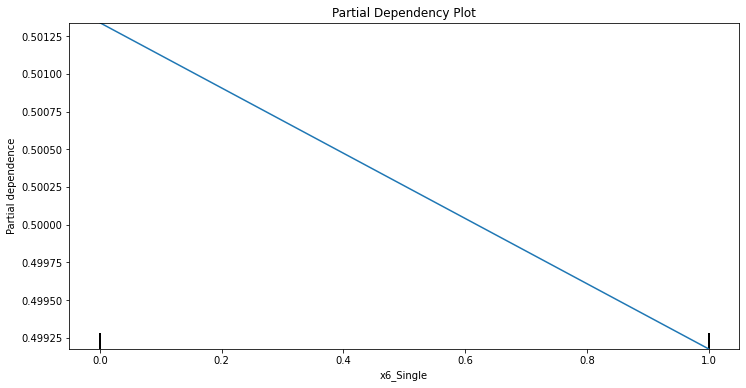

In [243]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Partial Dependency Plot")
PartialDependenceDisplay.from_estimator(xgb_classifier_final,
                                        X_test_x_cols_df_final,
                                        features = ['x6_Single'],
                                        feature_names = X_features,
                                        ax = ax);

### LIME - Local Interpretation of Model Explanation

In [244]:
!pip install lime

In [245]:
  X_features

['MonthlyIncome',
 'YearsInCurrentRole',
 'YearsAtCompany',
 'MonthlyRate',
 'TotalWorkingYears',
 'YearsWithCurrManager',
 'x0_Non-Travel',
 'x0_Travel_Frequently',
 'x0_Travel_Rarely',
 'x1_Human Resources',
 'x1_Research & Development',
 'x1_Sales',
 'x2_1',
 'x2_2',
 'x2_3',
 'x2_4',
 'x2_5',
 'x3_Human Resources',
 'x3_Life Sciences',
 'x3_Marketing',
 'x3_Medical',
 'x3_Other',
 'x3_Technical Degree',
 'x4_Female',
 'x4_Male',
 'x5_Healthcare Representative',
 'x5_Human Resources',
 'x5_Laboratory Technician',
 'x5_Manager',
 'x5_Manufacturing Director',
 'x5_Research Director',
 'x5_Research Scientist',
 'x5_Sales Executive',
 'x5_Sales Representative',
 'x6_Divorced',
 'x6_Married',
 'x6_Single',
 'x7_1',
 'x7_2',
 'x7_3',
 'x7_4',
 'x8_0',
 'x8_1',
 'x8_2',
 'x8_3']

In [246]:
import lime
import lime.lime_tabular

In [247]:
explainer = (lime
             .lime_tabular
             .LimeTabularExplainer(training_data = X_train_x_cols_df_final.to_numpy(), 
                                   training_labels = y_train,                                   
                                   feature_names = X_features, 
                                   class_names = ['No Attrition', 'Attrition'],
                                   categorical_features = ['x4_Male'],
                                   categorical_names = ['x4_Male'], 
                                   kernel_width=None,
                                   verbose = True ))

#### Explaining a case of No Attrition

In [248]:
X_test_x_cols_df_final.iloc[0]

MonthlyIncome                    2439.0
YearsInCurrentRole                  0.0
YearsAtCompany                      1.0
MonthlyRate                     14753.0
TotalWorkingYears                   1.0
YearsWithCurrManager                0.0
x0_Non-Travel                       0.0
x0_Travel_Frequently                1.0
x0_Travel_Rarely                    0.0
x1_Human Resources                  0.0
x1_Research & Development           1.0
x1_Sales                            0.0
x2_1                                0.0
x2_2                                1.0
x2_3                                0.0
x2_4                                0.0
x2_5                                0.0
x3_Human Resources                  0.0
x3_Life Sciences                    1.0
x3_Marketing                        0.0
x3_Medical                          0.0
x3_Other                            0.0
x3_Technical Degree                 0.0
x4_Female                           0.0
x4_Male                             1.0


In [249]:
exp = explainer.explain_instance( X_test_x_cols_df_final.iloc[0].to_numpy(), 
                                  xgb_classifier_final.predict_proba)

ValueError: ignored

#### Explaining a case of Attrition

In [250]:
X_test_x_cols_df_final.iloc[2]

MonthlyIncome                    2546.0
YearsInCurrentRole                  2.0
YearsAtCompany                      2.0
MonthlyRate                     18300.0
TotalWorkingYears                   6.0
YearsWithCurrManager                1.0
x0_Non-Travel                       0.0
x0_Travel_Frequently                0.0
x0_Travel_Rarely                    1.0
x1_Human Resources                  0.0
x1_Research & Development           1.0
x1_Sales                            0.0
x2_1                                0.0
x2_2                                0.0
x2_3                                0.0
x2_4                                0.0
x2_5                                1.0
x3_Human Resources                  0.0
x3_Life Sciences                    0.0
x3_Marketing                        0.0
x3_Medical                          0.0
x3_Other                            0.0
x3_Technical Degree                 1.0
x4_Female                           1.0
x4_Male                             0.0


In [251]:
exp = explainer.explain_instance( X_test_x_cols_df_final.iloc[2].to_numpy(), 
                                  xgb_classifier_final.predict_proba)

ValueError: ignored

In [252]:
exp.show_in_notebook(show_table=True, show_all=False)

NameError: ignored

### Using Shapley Values

In [253]:
!pip install shap

In [254]:
import shap

#### Explaining a case of No Attrition

In [255]:
row_to_show = 1
data_for_prediction = X_test_x_cols_df_final.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
xgb_classifier_final.predict_proba(data_for_prediction_array)

ValueError: ignored

In [256]:
explainer = shap.TreeExplainer(xgb_classifier_final)

shap_values = explainer.shap_values(data_for_prediction_array)

In [257]:
shap.initjs()
shap.force_plot( explainer.expected_value[1], 
                 shap_values[1], 
                 data_for_prediction,
                 figsize=(20, 2) )

IndexError: ignored

#### Explaining a case of Attrition

In [ ]:
row_to_show = 2
data_for_prediction = X_test_x_cols_df_final.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
xgb_classifier_final.predict_proba(data_for_prediction_array)

shap_values = explainer.shap_values(data_for_prediction_array)

shap.initjs()
shap.force_plot( explainer.expected_value[1], 
                 shap_values[1], 
                 data_for_prediction,
                 figsize=(20, 2) )

#### Global Explanation of SHAP

In [258]:
explainer = shap.TreeExplainer( xgb_classifier_final )
shap_values = explainer.shap_values( X_train_x_cols_df_final )

In [259]:
shap.summary_plot( shap_values[1], X_train_x_cols_df_final, plot_type = 'dot' )

AssertionError: ignored

In [261]:
explainer.expected_value

-0.011933837

In [262]:
shap.initjs()
shap.force_plot( explainer.expected_value[1], 
                 shap_values[1], 
                 X_train_x_cols_df_final )

IndexError: ignored

In [263]:
X_features

['MonthlyIncome',
 'YearsInCurrentRole',
 'YearsAtCompany',
 'MonthlyRate',
 'TotalWorkingYears',
 'YearsWithCurrManager',
 'x0_Non-Travel',
 'x0_Travel_Frequently',
 'x0_Travel_Rarely',
 'x1_Human Resources',
 'x1_Research & Development',
 'x1_Sales',
 'x2_1',
 'x2_2',
 'x2_3',
 'x2_4',
 'x2_5',
 'x3_Human Resources',
 'x3_Life Sciences',
 'x3_Marketing',
 'x3_Medical',
 'x3_Other',
 'x3_Technical Degree',
 'x4_Female',
 'x4_Male',
 'x5_Healthcare Representative',
 'x5_Human Resources',
 'x5_Laboratory Technician',
 'x5_Manager',
 'x5_Manufacturing Director',
 'x5_Research Director',
 'x5_Research Scientist',
 'x5_Sales Executive',
 'x5_Sales Representative',
 'x6_Divorced',
 'x6_Married',
 'x6_Single',
 'x7_1',
 'x7_2',
 'x7_3',
 'x7_4',
 'x8_0',
 'x8_1',
 'x8_2',
 'x8_3']

### Individual Conditional Expectations (ICE)

Text(0.5, 1.0, 'Individual Conditional Expectations')

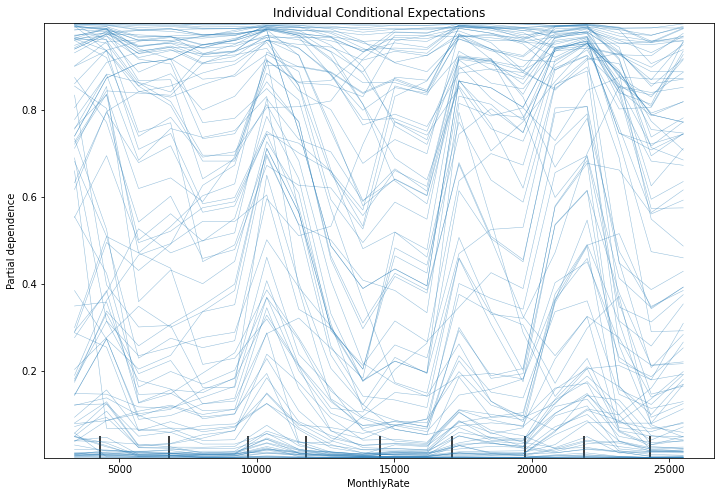

In [264]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Individual Conditional Expectations")

display = PartialDependenceDisplay.from_estimator(
    xgb_classifier_final,
    X_train_x_cols_df_final,
    features=["MonthlyRate"],
    kind="individual",
    subsample=100,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.5, "linewidth": 0.5},
    ax = ax
)

Text(0.5, 1.0, 'Individual Conditional Expectations')

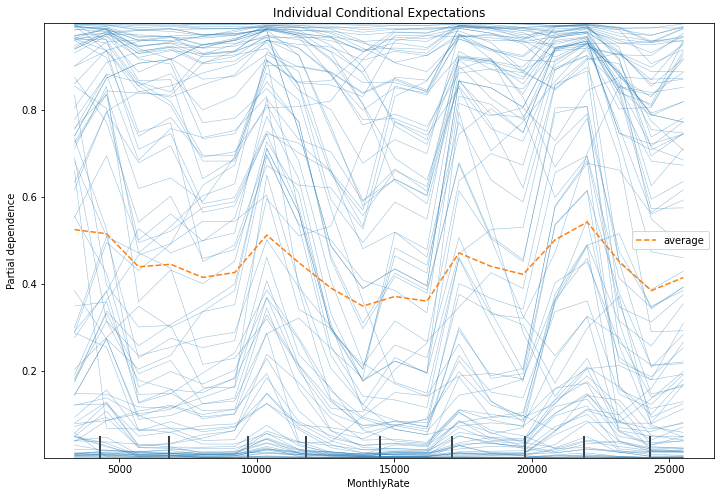

In [265]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Individual Conditional Expectations")

display = PartialDependenceDisplay.from_estimator(
    xgb_classifier_final,
    X_train_x_cols_df_final,
    features=["MonthlyRate"],
    kind="both",
    subsample=100,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.5, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    ax = ax
)

## Model Card Toolkit

In [266]:
#!pip install --upgrade pip==20.2
#!pip install -U seaborn scikit-learn model-card-toolkit

In [267]:
import base64
import uuid
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from io import BytesIO
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

In [268]:
# Utility function that will export a plot to a base-64 encoded string that the model card will accept.

def plot_to_str():
    img = BytesIO()
    plt.savefig(img, format='png')
    return base64.encodebytes(img.getvalue()).decode('utf-8')

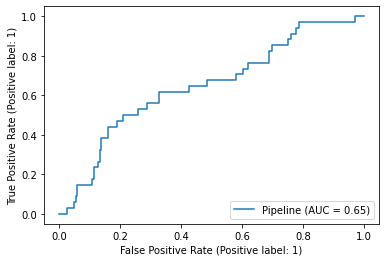

In [269]:
# Plot a ROC curve
plot_roc_curve(xgb_classifier_ohe, X_test, y_test)
roc_curve = plot_to_str()

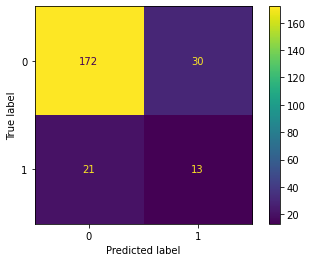

In [270]:
###Plot a confusion matrix

plot_confusion_matrix(xgb_classifier_ohe, X_test, y_test)
confusion_matrix = plot_to_str()

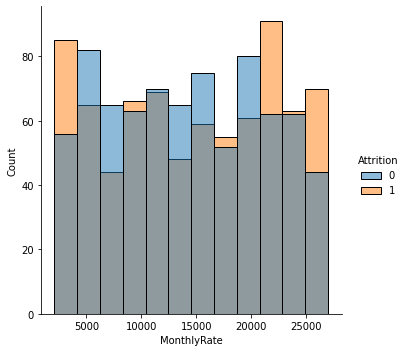

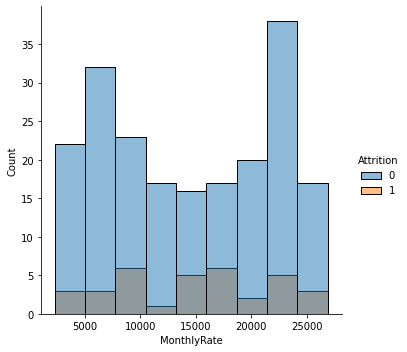

In [271]:
# Plot the mean radius feature for both the train and test sets

sns.displot(x=X_train['MonthlyRate'], hue=y_train)
mean_MonthlyRate_train = plot_to_str()

sns.displot(x=X_test['MonthlyRate'], hue=y_test)
mean_MonthlyRate_test = plot_to_str()

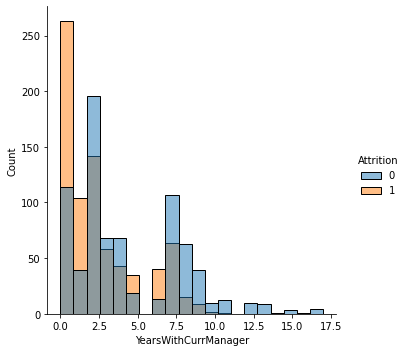

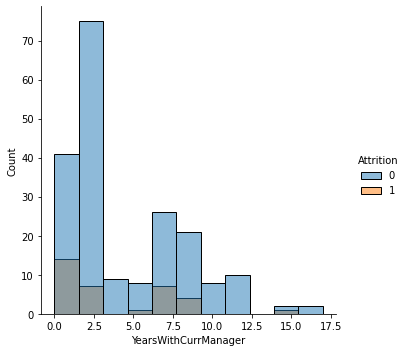

In [272]:
# Plot the mean texture feature for both the train and test sets

sns.displot(x=X_train['YearsWithCurrManager'], hue=y_train)
mean_YearsWithCurrManager_train = plot_to_str()

sns.displot(x=X_test['YearsWithCurrManager'], hue=y_test)
mean_YearsWithCurrManager_test = plot_to_str()

#### Initialize toolkit and model card

In [273]:
import model_card_toolkit as mctlib
from datetime import date

In [274]:
mct = mctlib.ModelCardToolkit()

model_card = mct.scaffold_assets()

In [275]:
model_card.model_details.name = 'IBM Employee Attrition HR Dataset'
model_card.model_details.overview = (
    'This model predicts whether an employee in a company will leave or not.')
model_card.model_details.owners = [
    mctlib.Owner(name= 'Model Cards Team', contact='krishna.khandelwal20@iimb.ac.in')
]
model_card.model_details.references = [
    mctlib.Reference(reference='https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset'),
    mctlib.Reference(reference='https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset')
]
model_card.model_details.version.name = str("Version 1.0")
model_card.model_details.version.date = str(date.today())

#### Add model uses and user details, ethical considerations and limitations

In [276]:
model_card.considerations.ethical_considerations = [mctlib.Risk(
    name=('Manual selection of image sections to digitize could create '
            'selection bias'),
    mitigation_strategy='Automate the selection process'
)]
model_card.considerations.limitations = [mctlib.Limitation(description='Employee Attrition diagnosis')]
model_card.considerations.use_cases = [mctlib.UseCase(description='Employee Attrition diagnosis')]
model_card.considerations.users = [mctlib.User(description='HR professionals'), mctlib.User(description='ML researchers')]

#### Add training and test dataset details

In [277]:
model_card.model_parameters.data.append(mctlib.Dataset(name="Training Dataset"))
model_card.model_parameters.data[0].graphics.description = (
  f'{len(X_train)} rows with {len(X_train.columns)} features')
model_card.model_parameters.data[0].graphics.collection = [
    mctlib.Graphic(image=mean_MonthlyRate_train),
    mctlib.Graphic(image=mean_YearsWithCurrManager_train)
]
model_card.model_parameters.data.append(mctlib.Dataset(name="Test Dataset"))
model_card.model_parameters.data[1].graphics.description = (
  f'{len(X_test)} rows with {len(X_test.columns)} features')
model_card.model_parameters.data[1].graphics.collection = [
    mctlib.Graphic(image=mean_MonthlyRate_test),
    mctlib.Graphic(image=mean_YearsWithCurrManager_test)
]

#### Add Model Evaluation Details

In [278]:
model_card.quantitative_analysis.graphics.description = (
  'ROC curve and confusion matrix')
model_card.quantitative_analysis.graphics.collection = [
    mctlib.Graphic(image=roc_curve),
    mctlib.Graphic(image=confusion_matrix)
]

In [279]:
mct.update_model_card(model_card)

### Generate model card

In [280]:
# Return the model card document as an HTML page

html = mct.export_format(output_file='/demo_cardv2.html')

In [281]:
from IPython import display
display.display(display.HTML(html))